In [1]:
suppressPackageStartupMessages(library(readxl))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(pheatmap))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(plyr)
library(purrr)
library(vegan)
#library(arrow)
library(parallel)
library(ComplexHeatmap)
library(ggsci)
library(tidyverse)

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize



Attaching package: ‘purrr’


The following object is masked from ‘package:plyr’:

    compact


Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4

Loading required package: grid

ComplexHeatmap version 2.16.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cit

# Create the ratio plot using JI file (padj <0.1)

In [11]:
J_index <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Figure_Notebooks/Intermediate_files/Jaccard_index/Jaccard_index_df_FvsM_each_celltype_padj0.1.csv")

In [12]:
#J_index

In [13]:
#Use DEG# in female/ DEG# (Female+Male-shared) on Y-axis and rank from high to low 
#     in X-axis in cell types that  have total DEGs # (f+M-s) > 10

In [14]:
J_index_modi <- J_index %>%
  mutate(Union = total_DEGs_female + total_DEGs_male - common_DEGs,
         Ratio_union = total_DEGs_female / Union,
        Unique_F_ratio = (total_DEGs_female-common_DEGs)/ Union)
         

# Print the updated dataframe
head(J_index_modi)


,X,celltype,jaccard_similarity,total_DEGs_male,total_DEGs_female,common_DEGs,Union,Ratio_union,Unique_F_ratio
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,1,ASDC,NA,0,0,0,0,NaN,NaN
2,2,Activated memory B cell,NA,0,0,0,0,NaN,NaN
3,3,Adaptive NK cell,NA,0,0,0,0,NaN,NaN
4,4,BaEoMaP cell,NA,0,0,0,0,NaN,NaN
5,5,C1Q+ CD16 monocyte,0,0,1,0,1,1,1
6,6,CD4 MAIT,NA,0,0,0,0,NaN,NaN


In [15]:
new_JI <- J_index_modi %>% filter(J_index_modi$Union > 10)
head(new_JI)
length(new_JI$celltype)
length(unique(new_JI$celltype))


# new_JI <- J_index_modi
# head(new_JI)
# new_JI <- new_JI %>% filter(common_DEGs > 20)
# length(unique(new_JI$celltype))

,X,celltype,jaccard_similarity,total_DEGs_male,total_DEGs_female,common_DEGs,Union,Ratio_union,Unique_F_ratio
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,8,CD8aa,0.00000000,11,18,0,29,0.6206897,0.62068966
2,15,CM CD4 T cell,0.05454545,34,24,3,55,0.4363636,0.38181818
3,16,CM CD8 T cell,0.04736842,173,26,9,190,0.1368421,0.08947368
4,18,Core CD14 monocyte,0.00000000,10,64,0,74,0.8648649,0.86486486
5,20,Core memory B cell,0.03571429,16,13,1,28,0.4642857,0.42857143
6,22,Core naive CD4 T cell,0.16430020,307,267,81,493,0.5415822,0.37728195


[1] 17

[1] 17

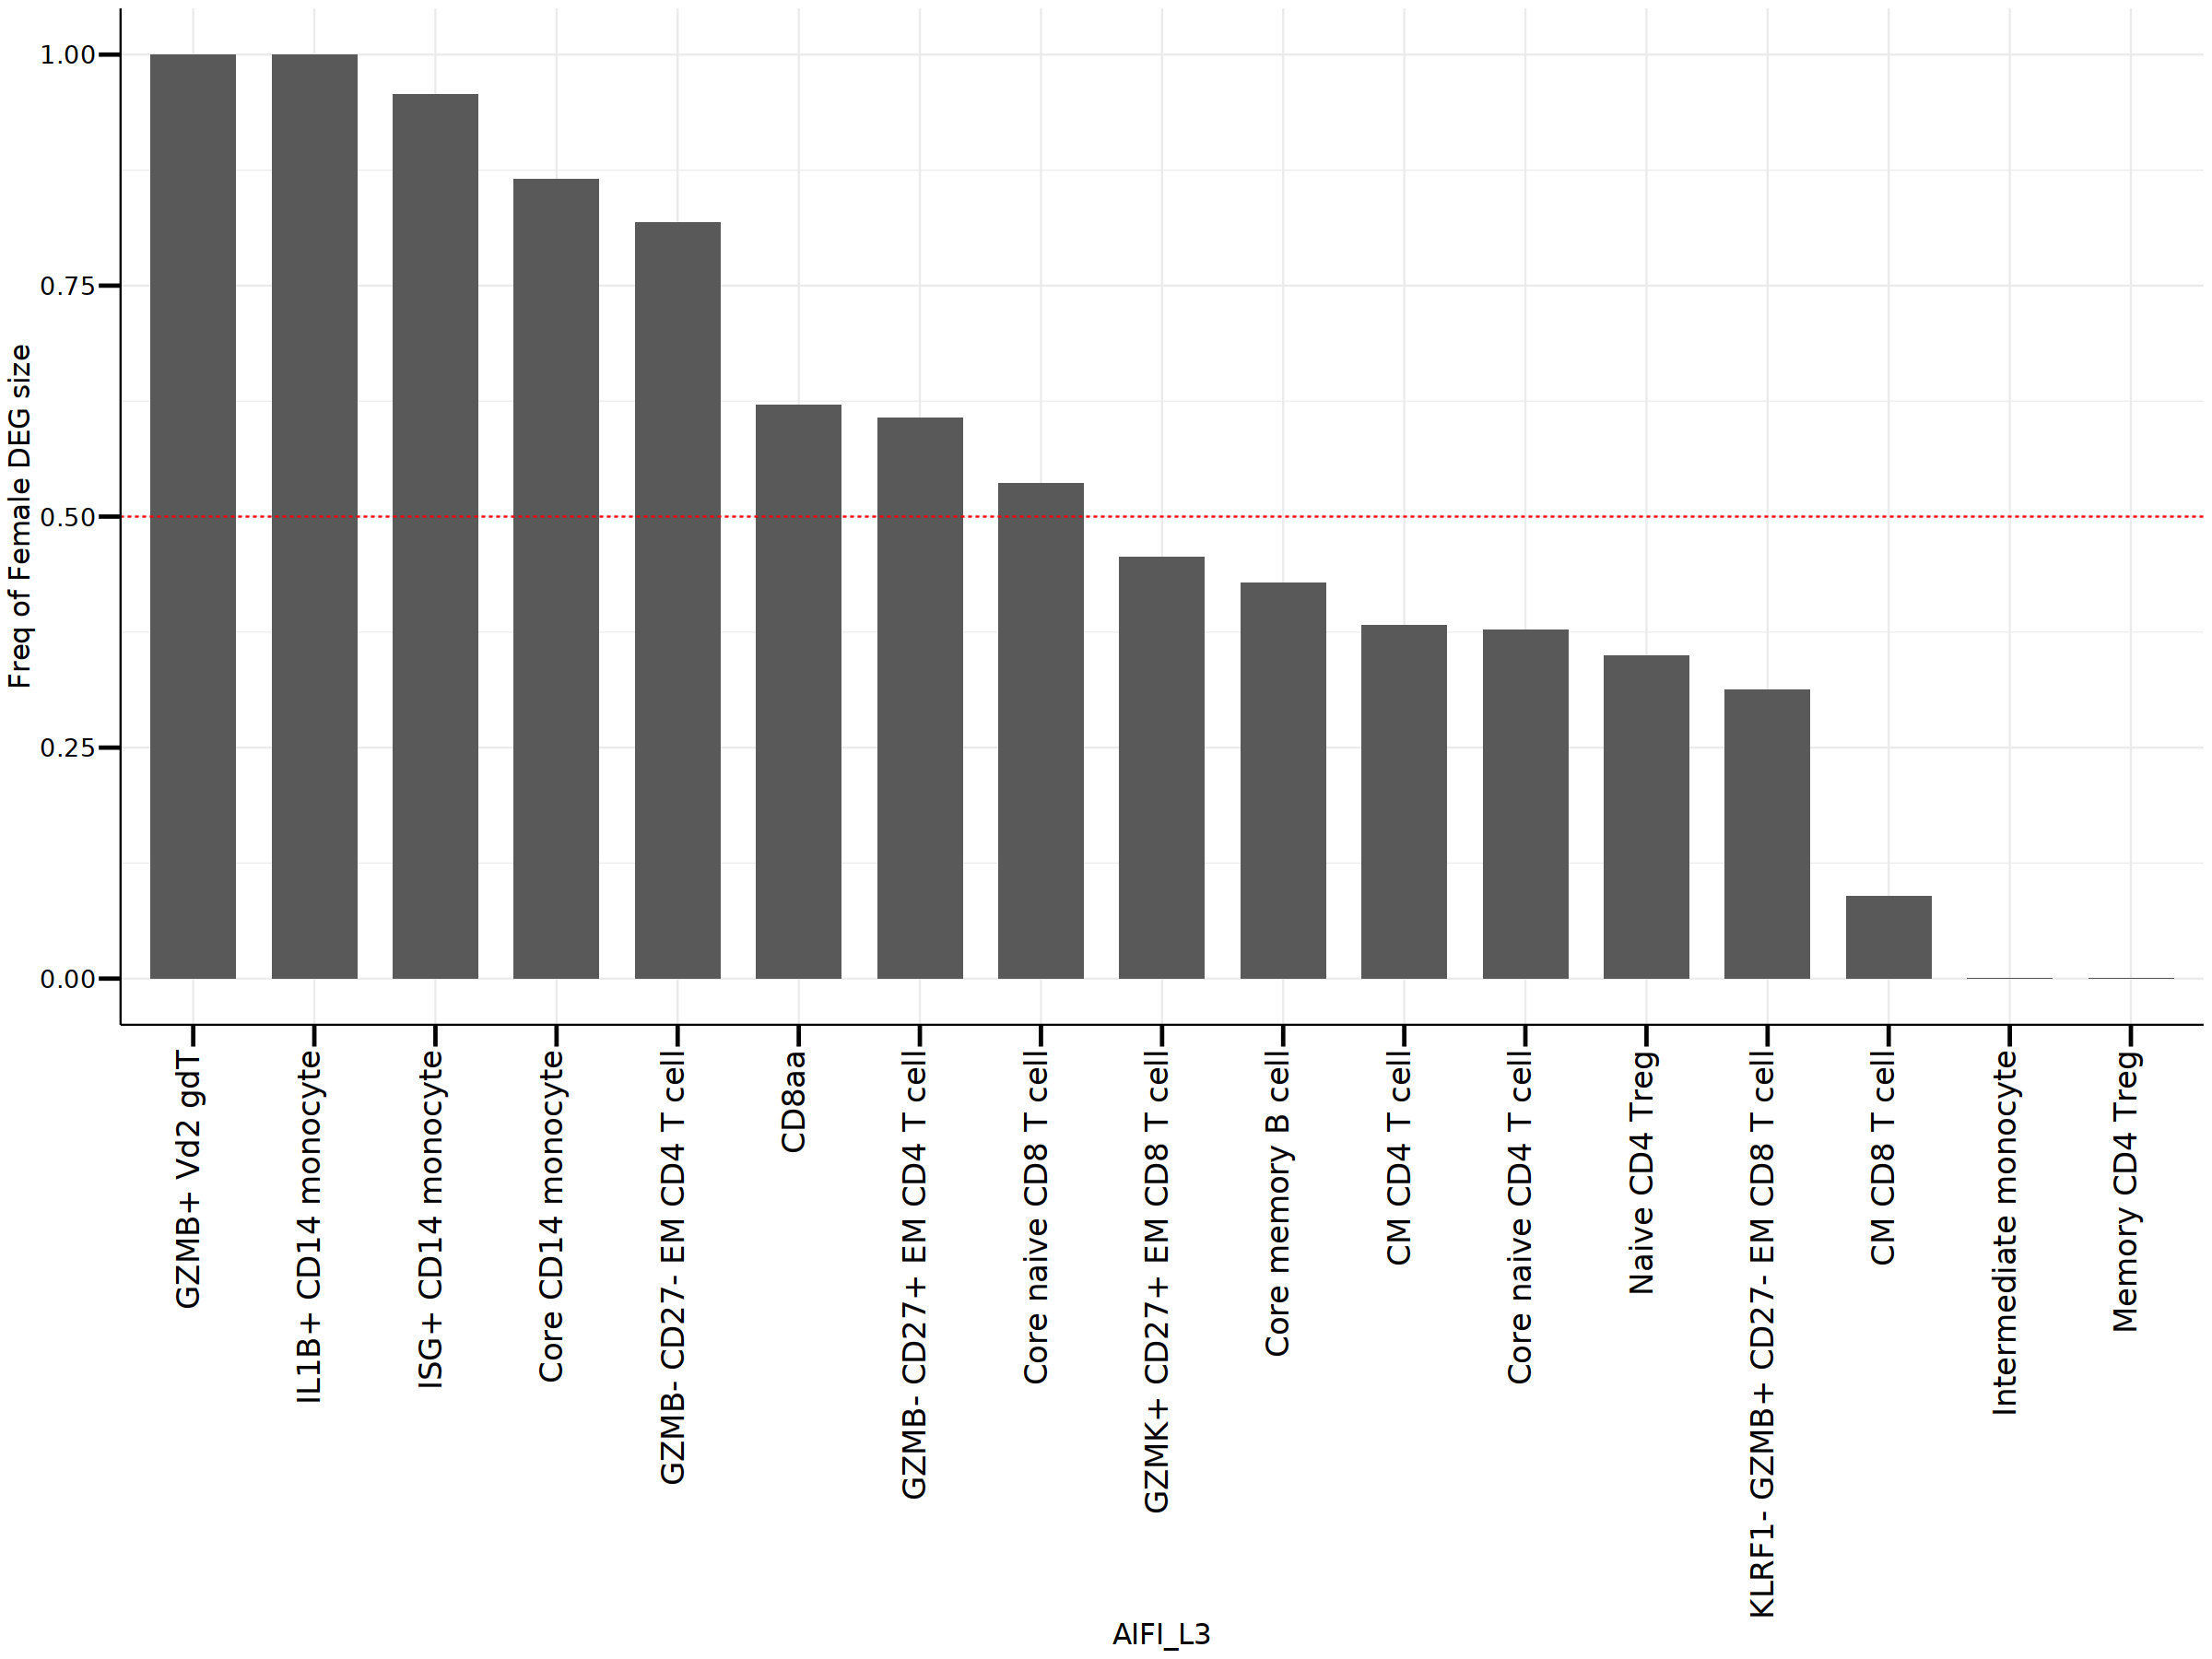

In [16]:
library(ggplot2)

# Assuming your dataframe is named df
# Replace df with the actual name of your dataframe if different

# Sort dataframe by Data_y in descending order
new_JI <- new_JI[order(-new_JI$Unique_F_ratio),]

# Convert cell_type to factor with levels arranged in descending order
new_JI$celltype <- factor(new_JI$celltype, levels = new_JI$celltype)

options(repr.plot.width = 20, repr.plot.height = 15)
# Create JI plot
JI_plot <- ggplot(new_JI, aes(x = celltype, y = Unique_F_ratio)) +
  geom_bar(stat = "identity", width = 0.7) +
  #geom_segment(aes(x = celltype, xend = celltype, y = 0, yend = Unique_F_ratio), color = "skyblue") +
  #geom_point(color = "blue", size = 3) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red")+
  theme_minimal() + 
  #coord_flip() + 
  labs(x = "AIFI_L3", y = "Freq of Female DEG size") +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  )

# Print the plot
print(JI_plot)



In [17]:
# save the celltype order to use it on the nDEGs plot
# Specify the order of cell types
celltype_order <- new_JI$celltype

In [18]:
length(celltype_order)

[1] 17

# Create nDEGs plot for each celltype (p <= 0.1)

In [19]:
master <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/CertPro_analysis/scripts/Figure_Notebooks/Intermediate_files/master_combined_DEG_list_all_celltypes_forfigs.csv")

In [20]:
head(master)

,X,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,contrast,Direction,gene,celltype,sex
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,1.4553376,-1.58887408,0.3911621,-4.0619325,4.866815e-05,0.3688559,cohort.cohortGuid,BR1,CCDC174,ASDC,Female
2,2,0.3984625,0.41653866,0.5699233,0.7308679,4.648598e-01,0.9968973,cohort.cohortGuid,BR2,AL669831.5,ASDC,Female
3,3,1.6559504,0.25216783,0.3641720,0.6924415,4.886601e-01,0.9968973,cohort.cohortGuid,BR2,NOC2L,ASDC,Female
4,4,1.2866563,-0.97078515,0.5119361,-1.8963013,5.792021e-02,0.9968973,cohort.cohortGuid,BR1,ISG15,ASDC,Female
5,5,2.7154615,-0.05010603,0.2936791,-0.1706149,8.645266e-01,0.9968973,cohort.cohortGuid,BR1,SDF4,ASDC,Female
6,6,1.1378577,-0.29946048,0.4050389,-0.7393377,4.597020e-01,0.9968973,cohort.cohortGuid,BR1,B3GALT6,ASDC,Female


In [21]:
library(dplyr)
library(tidyr)

# Create all possible combinations of celltype, Direction, and type
all_combinations <- expand.grid(celltype = unique(master$celltype),
                                Direction = unique(master$Direction),
                                sex = unique(master$sex))

# Summarize the data
master_summary <- master %>%
  dplyr::mutate(Expression = case_when(log2FoldChange >= 0.1 & padj <= 0.1 ~ "BR2",
                                 log2FoldChange <= -0.1 & padj <= 0.1 ~ "BR1",
                                 TRUE ~ "Unchanged")) %>%
  dplyr::filter(!Expression == 'Unchanged') %>%
  dplyr::group_by(celltype, Direction, sex) %>%
  dplyr::summarise(count = n(), .groups = 'drop')

# Left join with all_combinations and fill missing counts with 0
master_complete <- left_join(all_combinations, master_summary, by = c("celltype", "Direction", "sex")) %>%
  dplyr::mutate(count = replace_na(count, 0)) %>% 
  filter(!is.na(Direction)) # Remove rows with NA in the Direction column



# Check the number of unique celltypes
length(unique(master_complete$celltype))


head(master_complete)
#all_combinations


[1] 71

,celltype,Direction,sex,count
,<chr>,<chr>,<chr>,<int>
1,ASDC,BR1,Female,0
2,Activated memory B cell,BR1,Female,0
3,Adaptive NK cell,BR1,Female,0
4,BaEoMaP cell,BR1,Female,0
5,C1Q+ CD16 monocyte,BR1,Female,0
6,CD4 MAIT,BR1,Female,0


In [22]:
dim(master_complete)

[1] 284   4

In [6]:
# master_complete_1 <- master_complete %>% filter(celltype == "ASDC")
# master_complete_1

In [7]:
## old method
# library(dplyr)
# library(tidyr)

# master<- master%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "BR2",
#                                                      log2FoldChange <= -0.1 & padj <= 0.1 ~ "BR1",
#                                                      TRUE ~ "Unchanged"))

# master<-master %>% filter(Year=='Y1')



# master_2 <- master %>%
#   dplyr::mutate(Expression = case_when(log2FoldChange >= 0.1 & padj <= 0.1 ~ "BR2",
#                                  log2FoldChange <= -0.1 & padj <= 0.1 ~ "BR1",
#                                  TRUE ~ "Unchanged")) %>%
#   dplyr::filter(!Expression == 'Unchanged') %>%
#   dplyr::group_by(celltype, Direction, type) %>%
#   dplyr::summarise(count = n(), .groups = 'drop') %>%
#   tidyr::complete(celltype, Direction, type, fill = list(count = 0)) # Add missing combinations and fill with 0 

# head(master_2) 
# length(unique(master_2$celltype))  ## Only 38/71 celltypes had significant DEGs (p<=0.1)

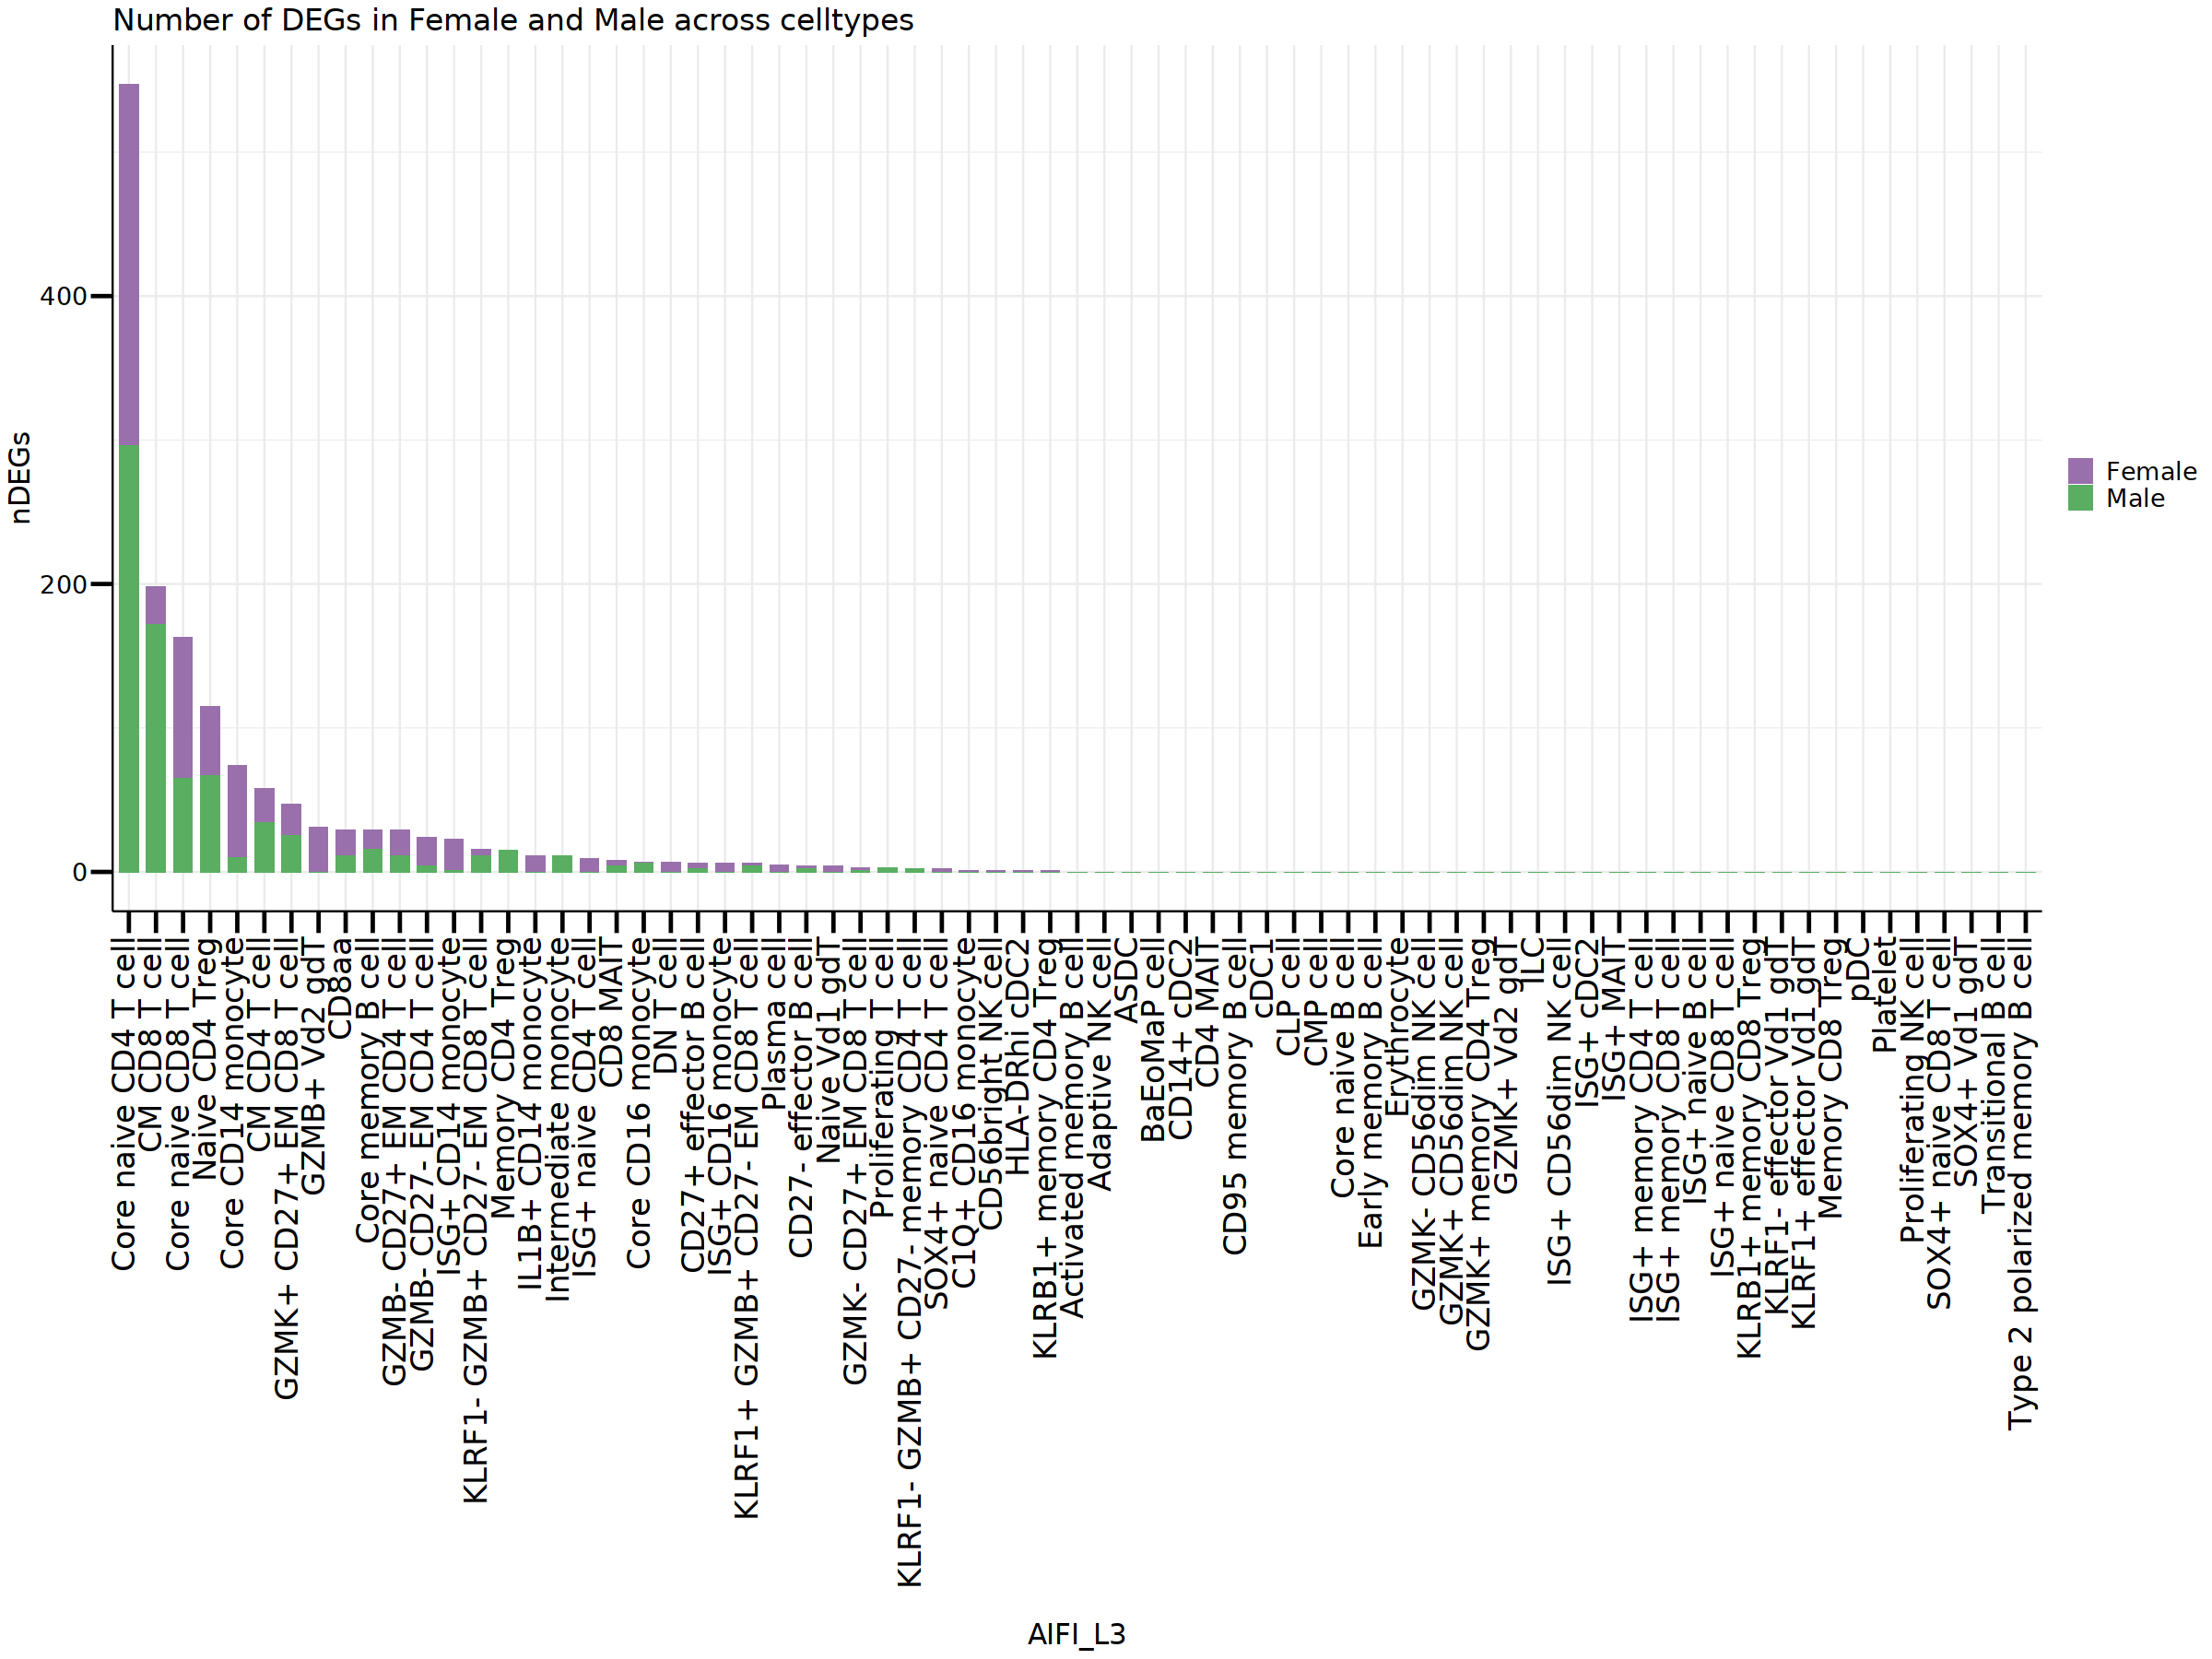

In [23]:
## stacked plot of nDEG counts

pastel_colors <- c("#9970ab", "#5aae61")  # Example pastel colors


options(repr.plot.width = 20, repr.plot.height = 15)

ggplot(master_complete, aes(x = reorder(celltype, desc(count)), y = count, fill = sex)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_fill_manual(values = pastel_colors) +  # Set pastel colors
  labs(title = "Number of DEGs in Female and Male across celltypes", x = "\nAIFI_L3", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  ) 

In [28]:
master_complete

,celltype,Direction,sex,count
,<fct>,<chr>,<chr>,<int>
8,CD8aa,BR1,Female,8
15,CM CD4 T cell,BR1,Female,11
16,CM CD8 T cell,BR1,Female,10
18,Core CD14 monocyte,BR1,Female,21
20,Core memory B cell,BR1,Female,8
22,Core naive CD4 T cell,BR1,Female,92
23,Core naive CD8 T cell,BR1,Female,33
27,GZMB+ Vd2 gdT,BR1,Female,7
28,GZMB- CD27+ EM CD4 T cell,BR1,Female,11


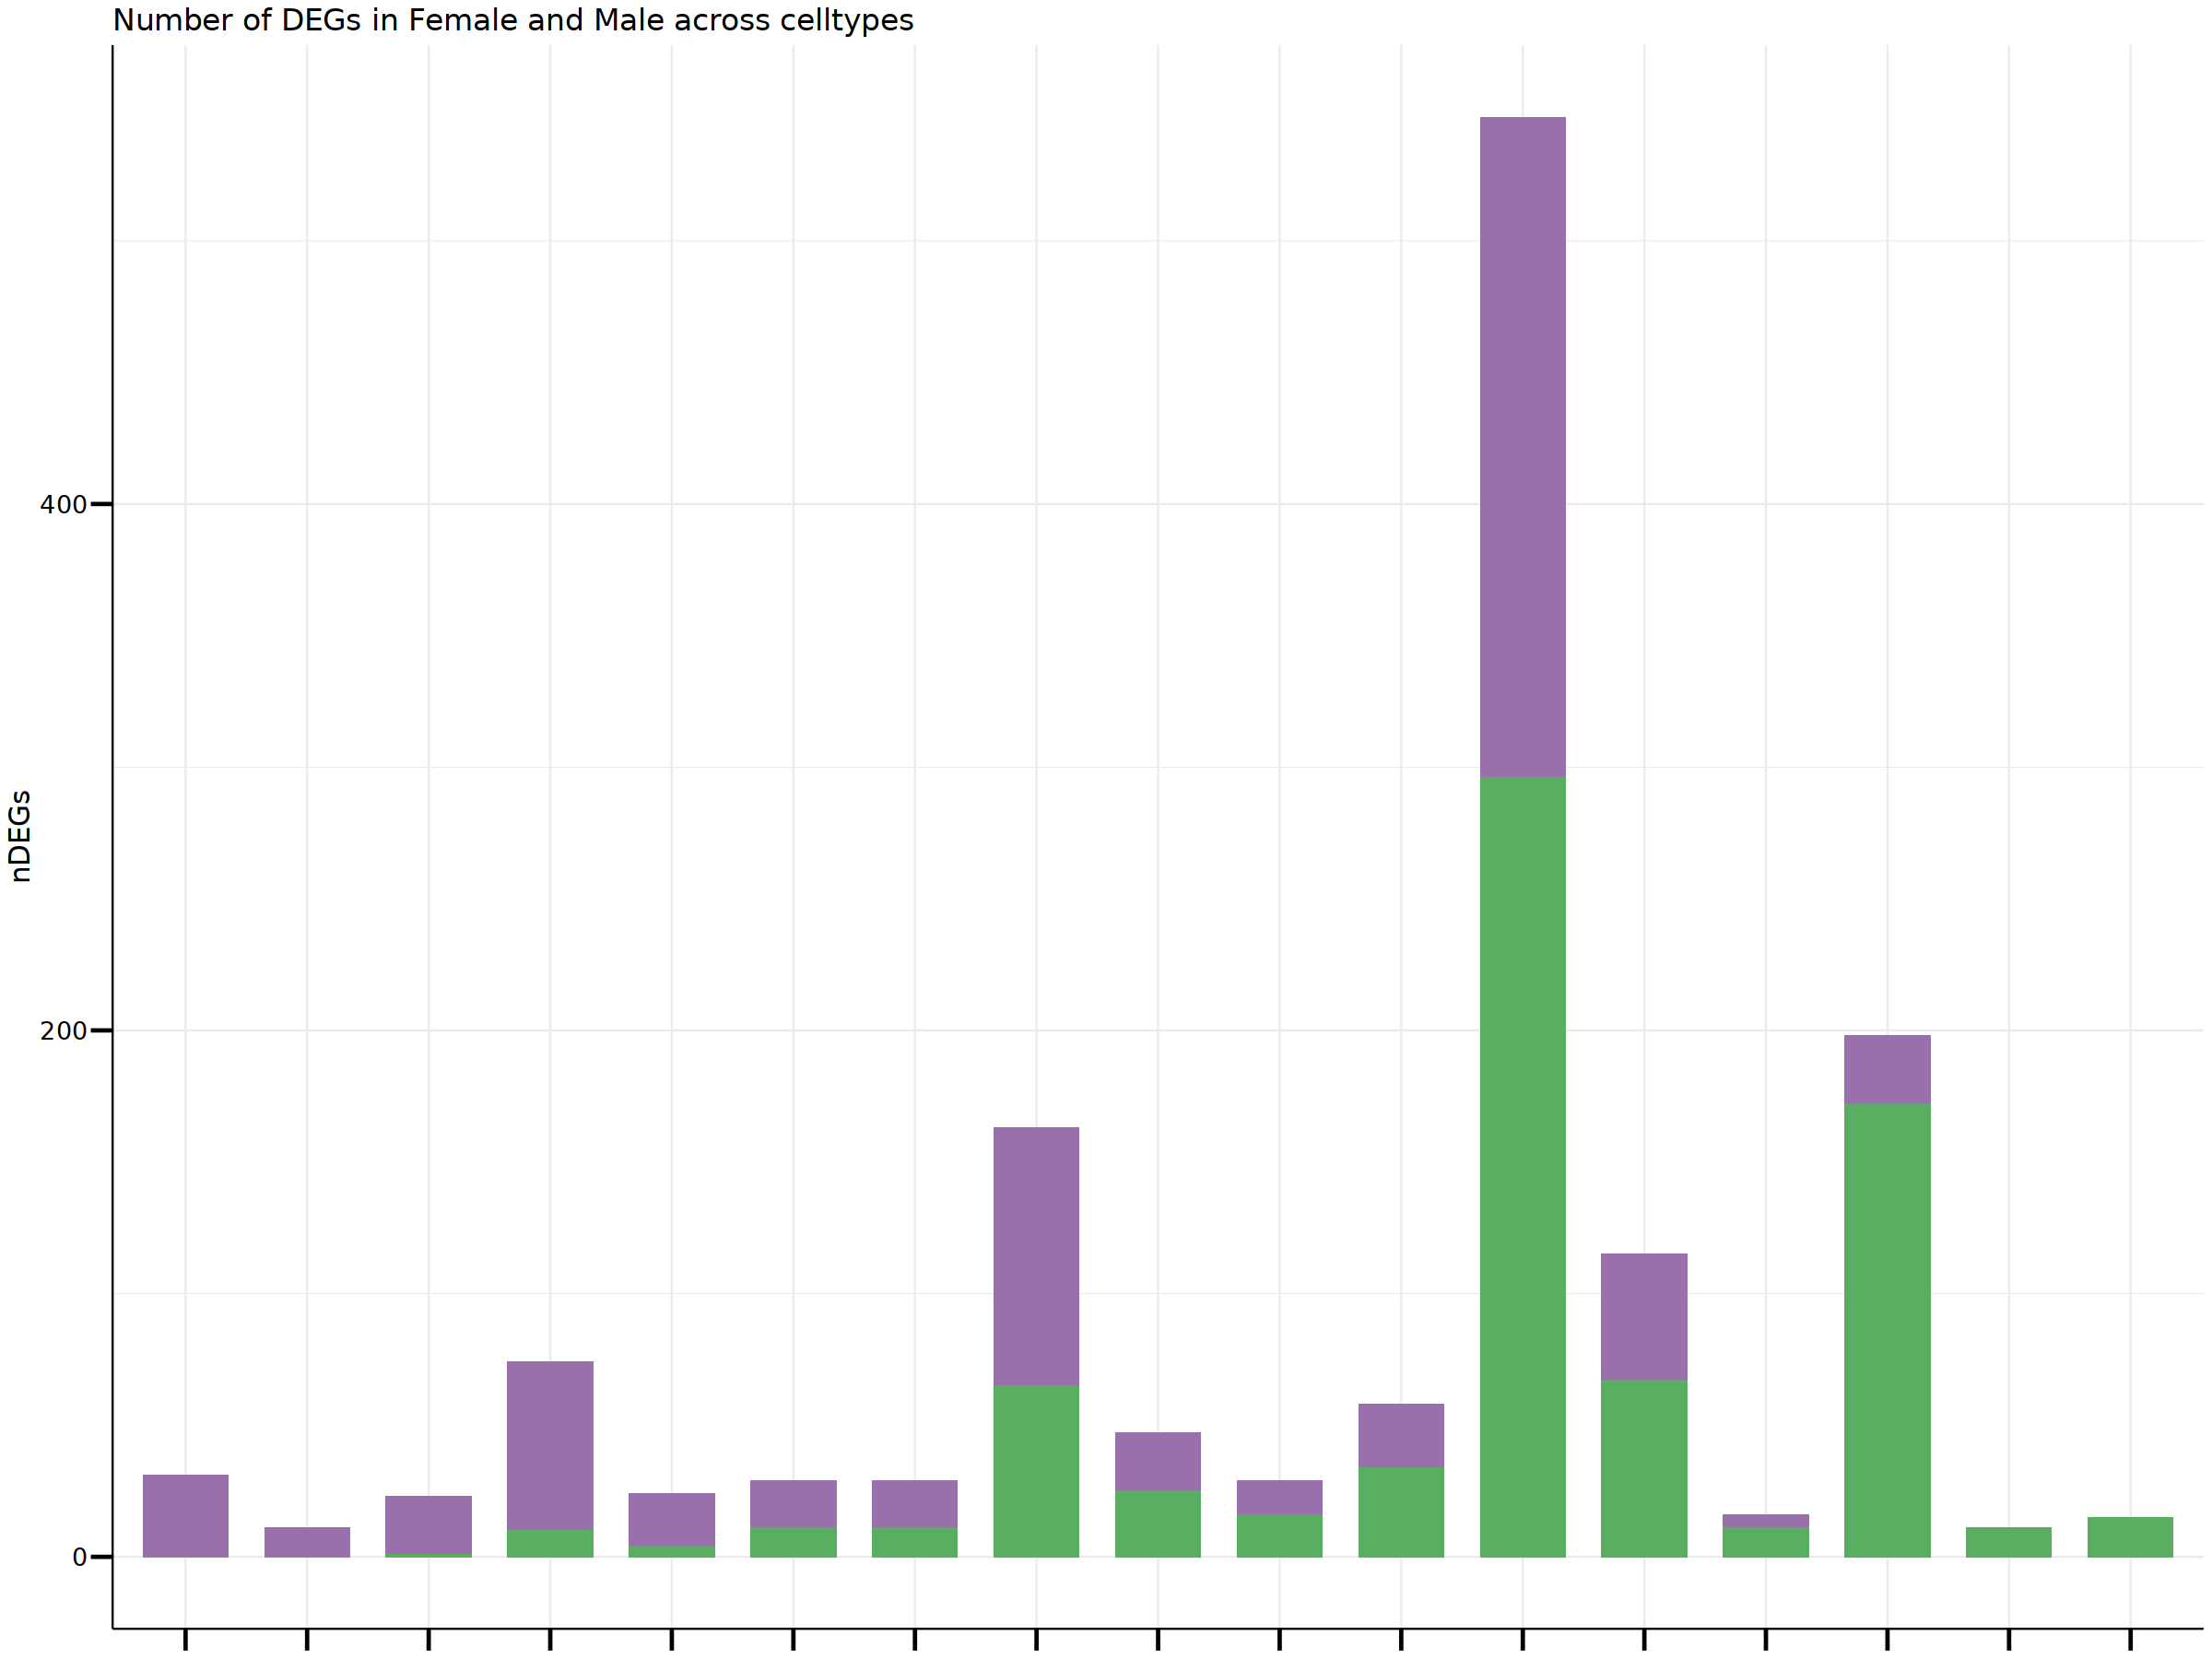

In [24]:
pastel_colors <- c( "#9970ab", "#5aae61" )  # Example pastel colors

#celltype order from the JI plot
master_complete$celltype <- factor(master_complete$celltype, levels = celltype_order)

# Remove rows with NA values in the 'celltype' column
master_complete <- master_complete[complete.cases(master_complete$celltype), ]


#reorder(celltype, desc(count))
#options(repr.plot.width = 20, repr.plot.height = 5)

nDEG_plot <- ggplot(master_complete, aes(x = celltype, y = count, fill = sex)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_fill_manual(values = pastel_colors) +  # Set pastel colors
  labs(title = "Number of DEGs in Female and Male across celltypes", x = "\nAIFI_L3", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  ) +
  theme(axis.title.x = element_blank(), axis.text.x = element_blank()) + theme(legend.position = "none")

nDEG_plot

In [34]:
master_complete$celltype

[1] CD8aa                            CM CD4 T cell                   
 [3] CM CD8 T cell                    Core CD14 monocyte              
 [5] Core memory B cell               Core naive CD4 T cell           
 [7] Core naive CD8 T cell            GZMB+ Vd2 gdT                   
 [9] GZMB- CD27+ EM CD4 T cell        GZMB- CD27- EM CD4 T cell       
[11] GZMK+ CD27+ EM CD8 T cell        IL1B+ CD14 monocyte             
[13] ISG+ CD14 monocyte               Intermediate monocyte           
[15] KLRF1- GZMB+ CD27- EM CD8 T cell Memory CD4 Treg                 
[17] Naive CD4 Treg                   CD8aa                           
[19] CM CD4 T cell                    CM CD8 T cell                   
[21] Core CD14 monocyte               Core memory B cell              
[23] Core naive CD4 T cell            Core naive CD8 T cell           
[25] GZMB+ Vd2 gdT                    GZMB- CD27+ EM CD4 T cell       
[27] GZMB- CD27- EM CD4 T cell        GZMK+ CD27+ EM CD8 T cell       
[29] IL1B+ CD14 monocyte              ISG+ CD14 monocyte              
[31] Intermediate monocyte            KLRF1- GZMB+ CD27- EM CD8 T cell
[33] Memory CD4 Treg                  Naive CD4 Treg                  
[35] CD8aa                            CM CD4 T cell                   
[37] CM CD8 T cell                    Core CD14 monocyte              
[39] Core memory B cell               Core naive CD4 T cell           
[41] Core naive CD8 T cell            GZMB+ Vd2 gdT                   
[43] GZMB- CD27+ EM CD4 T cell        GZMB- CD27- EM CD4 T cell       
[45] GZMK+ CD27+ EM CD8 T cell        IL1B+ CD14 monocyte             
[47] ISG+ CD14 monocyte               Intermediate monocyte           
[49] KLRF1- GZMB+ CD27- EM CD8 T cell Memory CD4 Treg                 
[51] Naive CD4 Treg                   CD8aa                           
[53] CM CD4 T cell                    CM CD8 T cell                   
[55] Core CD14 monocyte               Core memory B cell              
[57] Core naive CD4 T cell            Core naive CD8 T cell           
[59] GZMB+ Vd2 gdT                    GZMB- CD27+ EM CD4 T cell       
[61] GZMB- CD27- EM CD4 T cell        GZMK+ CD27+ EM CD8 T cell       
[63] IL1B+ CD14 monocyte              ISG+ CD14 monocyte              
[65] Intermediate monocyte            KLRF1- GZMB+ CD27- EM CD8 T cell
[67] Memory CD4 Treg                  Naive CD4 Treg                  
17 Levels: GZMB+ Vd2 gdT IL1B+ CD14 monocyte ... Memory CD4 Treg

# Stack the nDEG and JI rato plot together

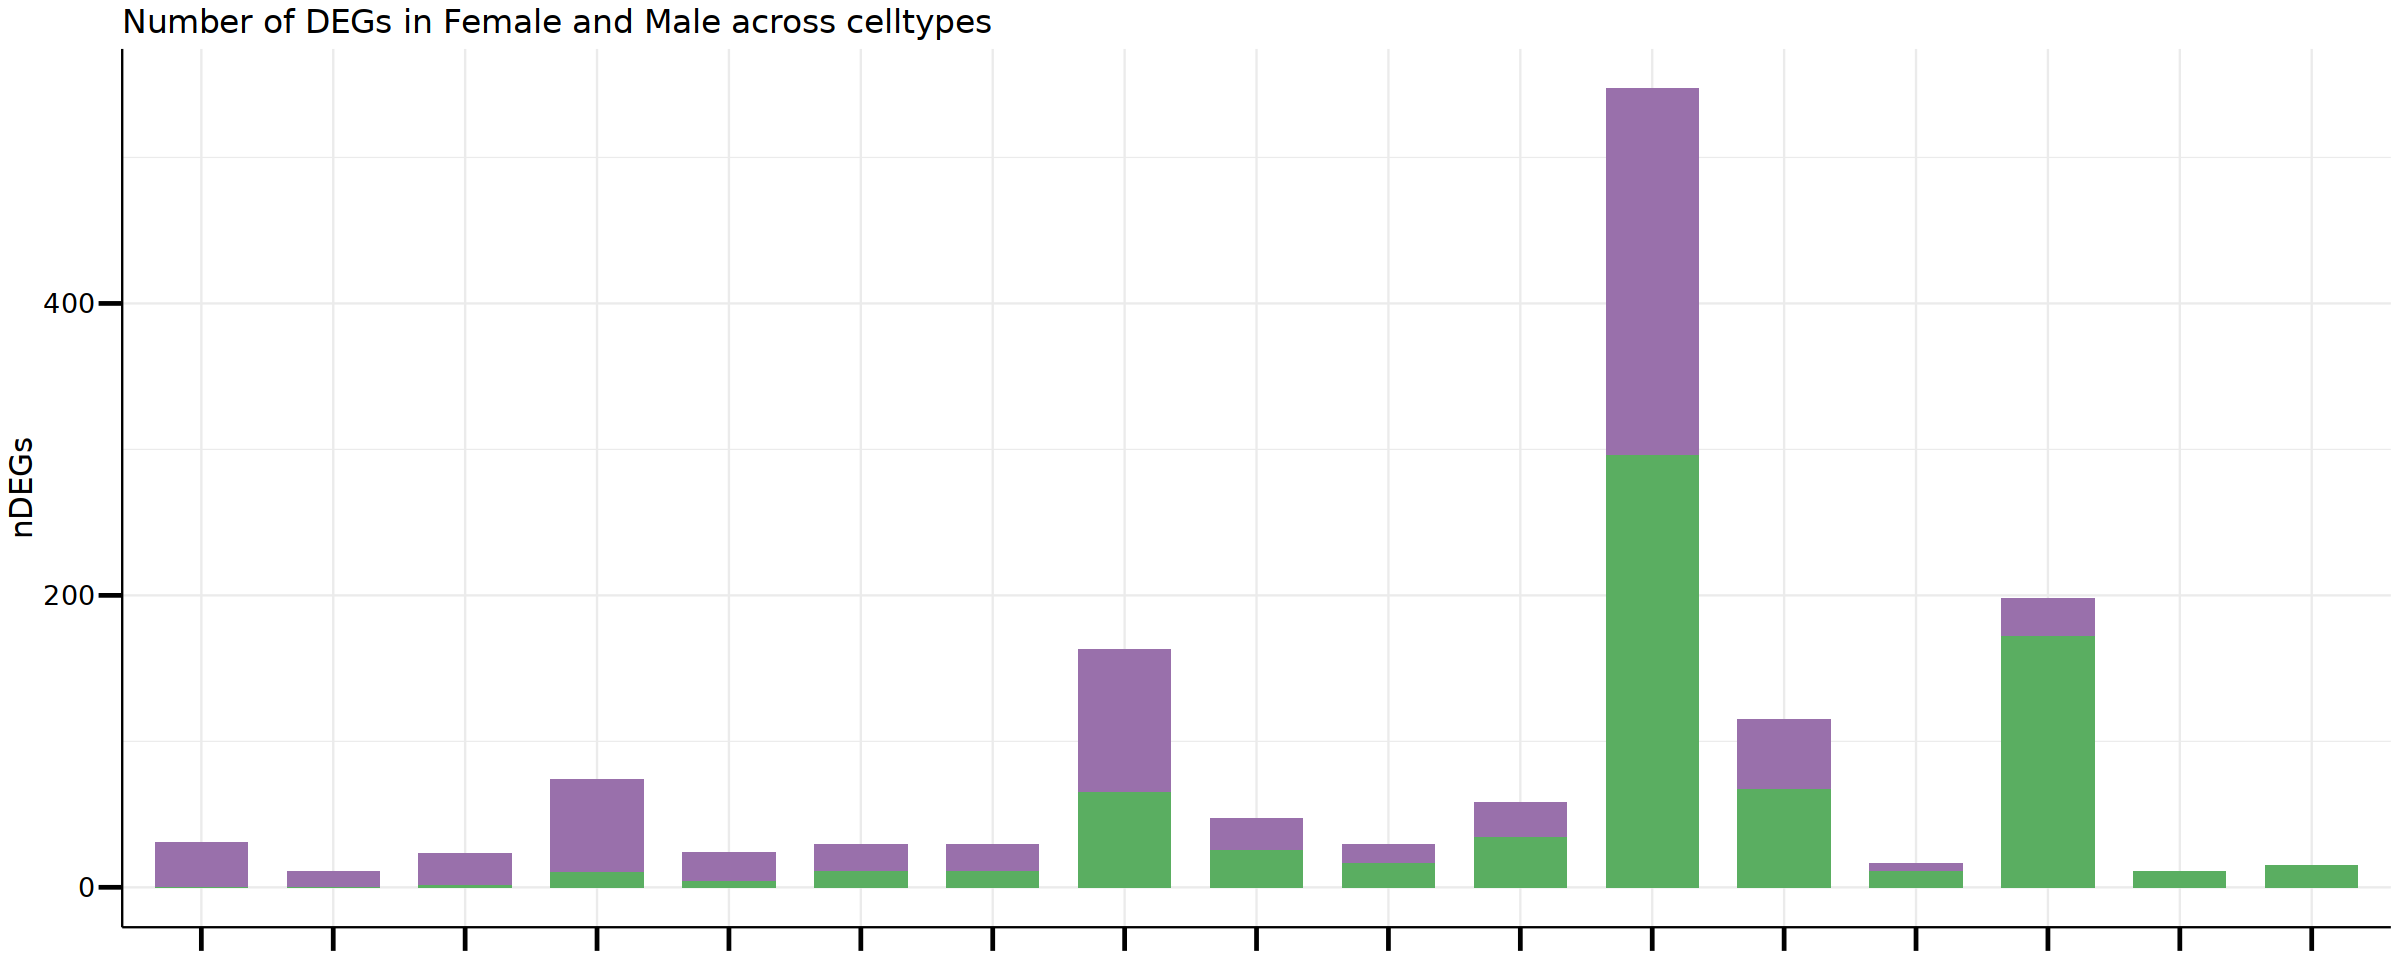

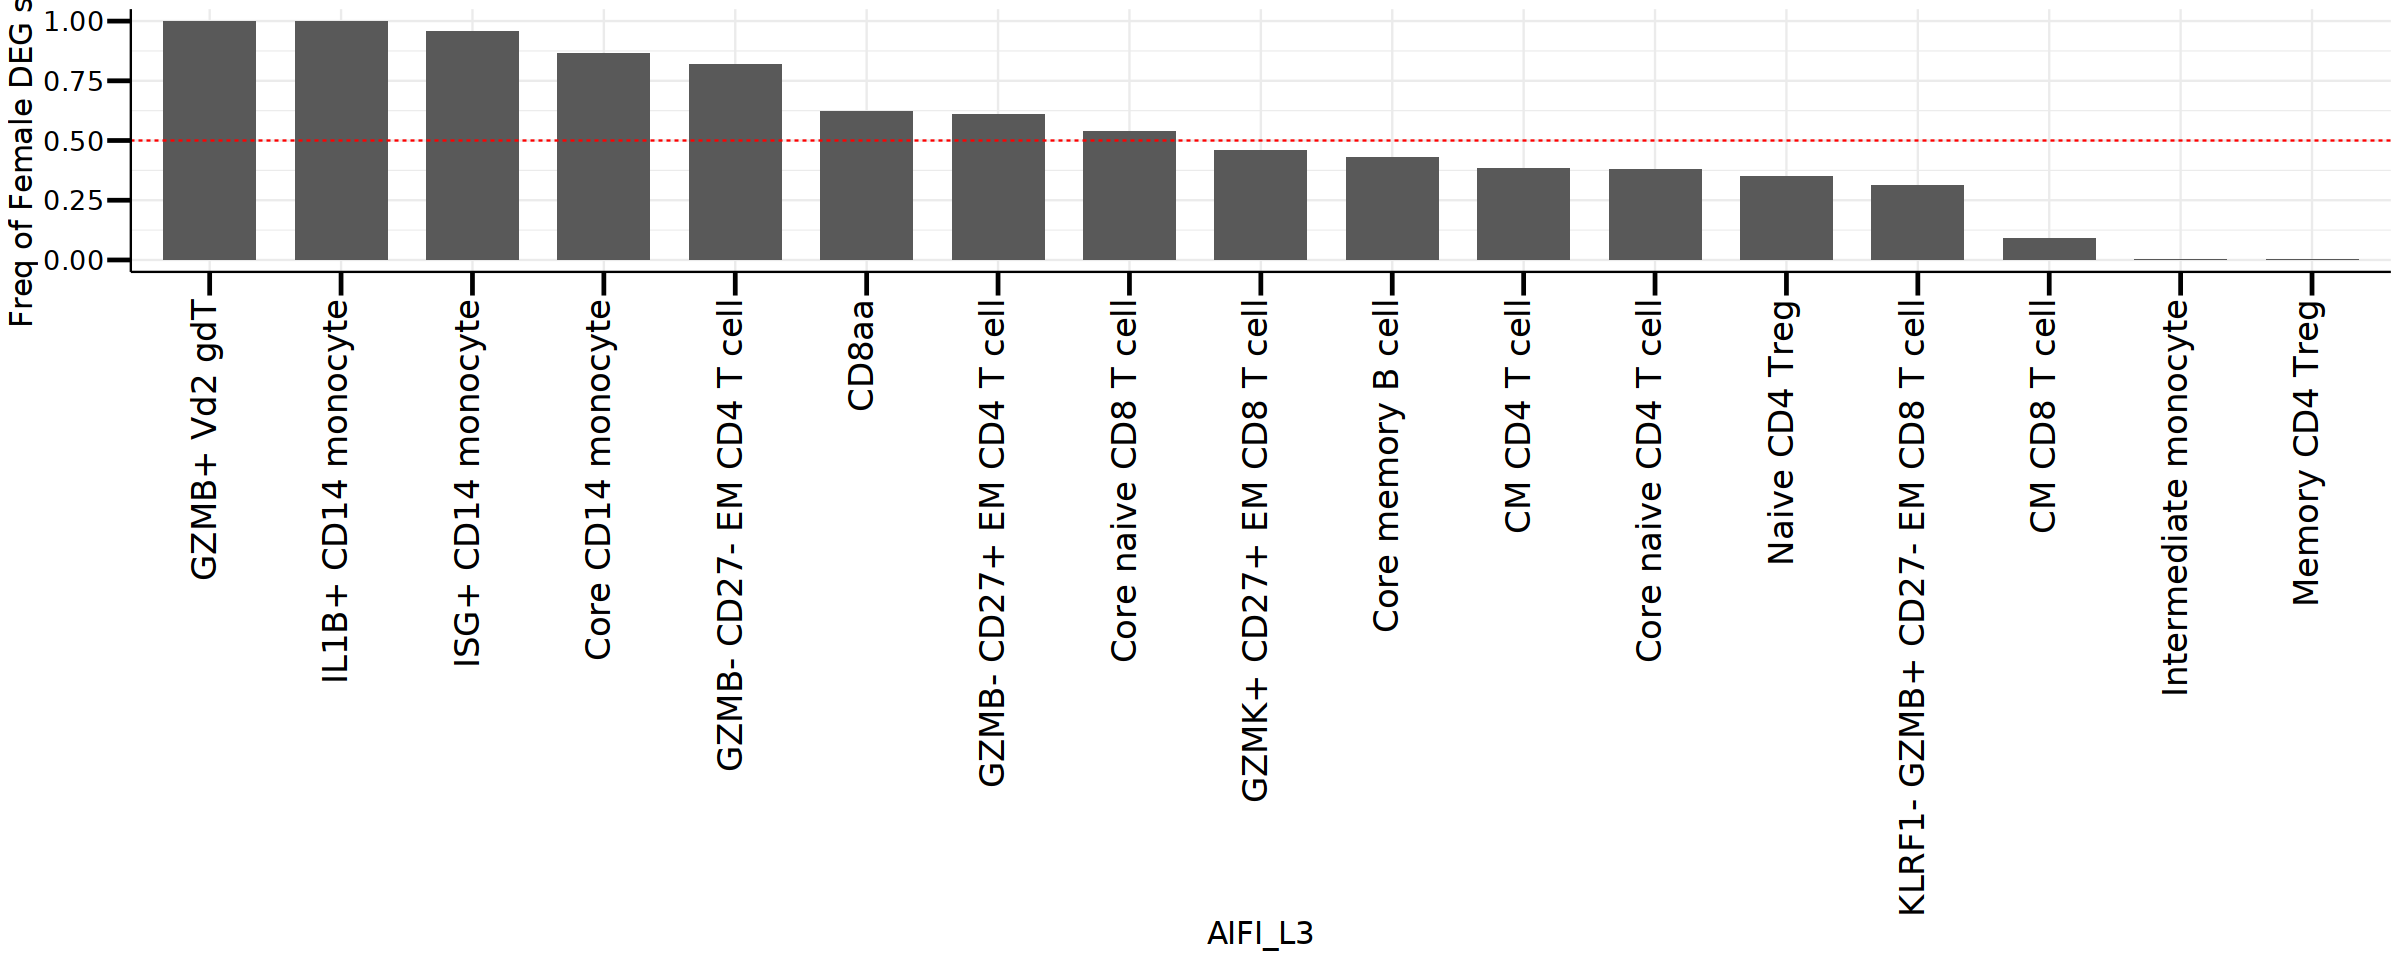

In [29]:
options(repr.plot.width = 20, repr.plot.height = 8)

# Set the same x-axis limits for both plots
x_limits <- c(1, length(celltype_order))

# Print the plots

print(nDEG_plot + coord_cartesian(xlim = x_limits))
print(JI_plot + coord_cartesian(xlim = x_limits))



In [31]:
library(ggpubr)
library(gridExtra)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




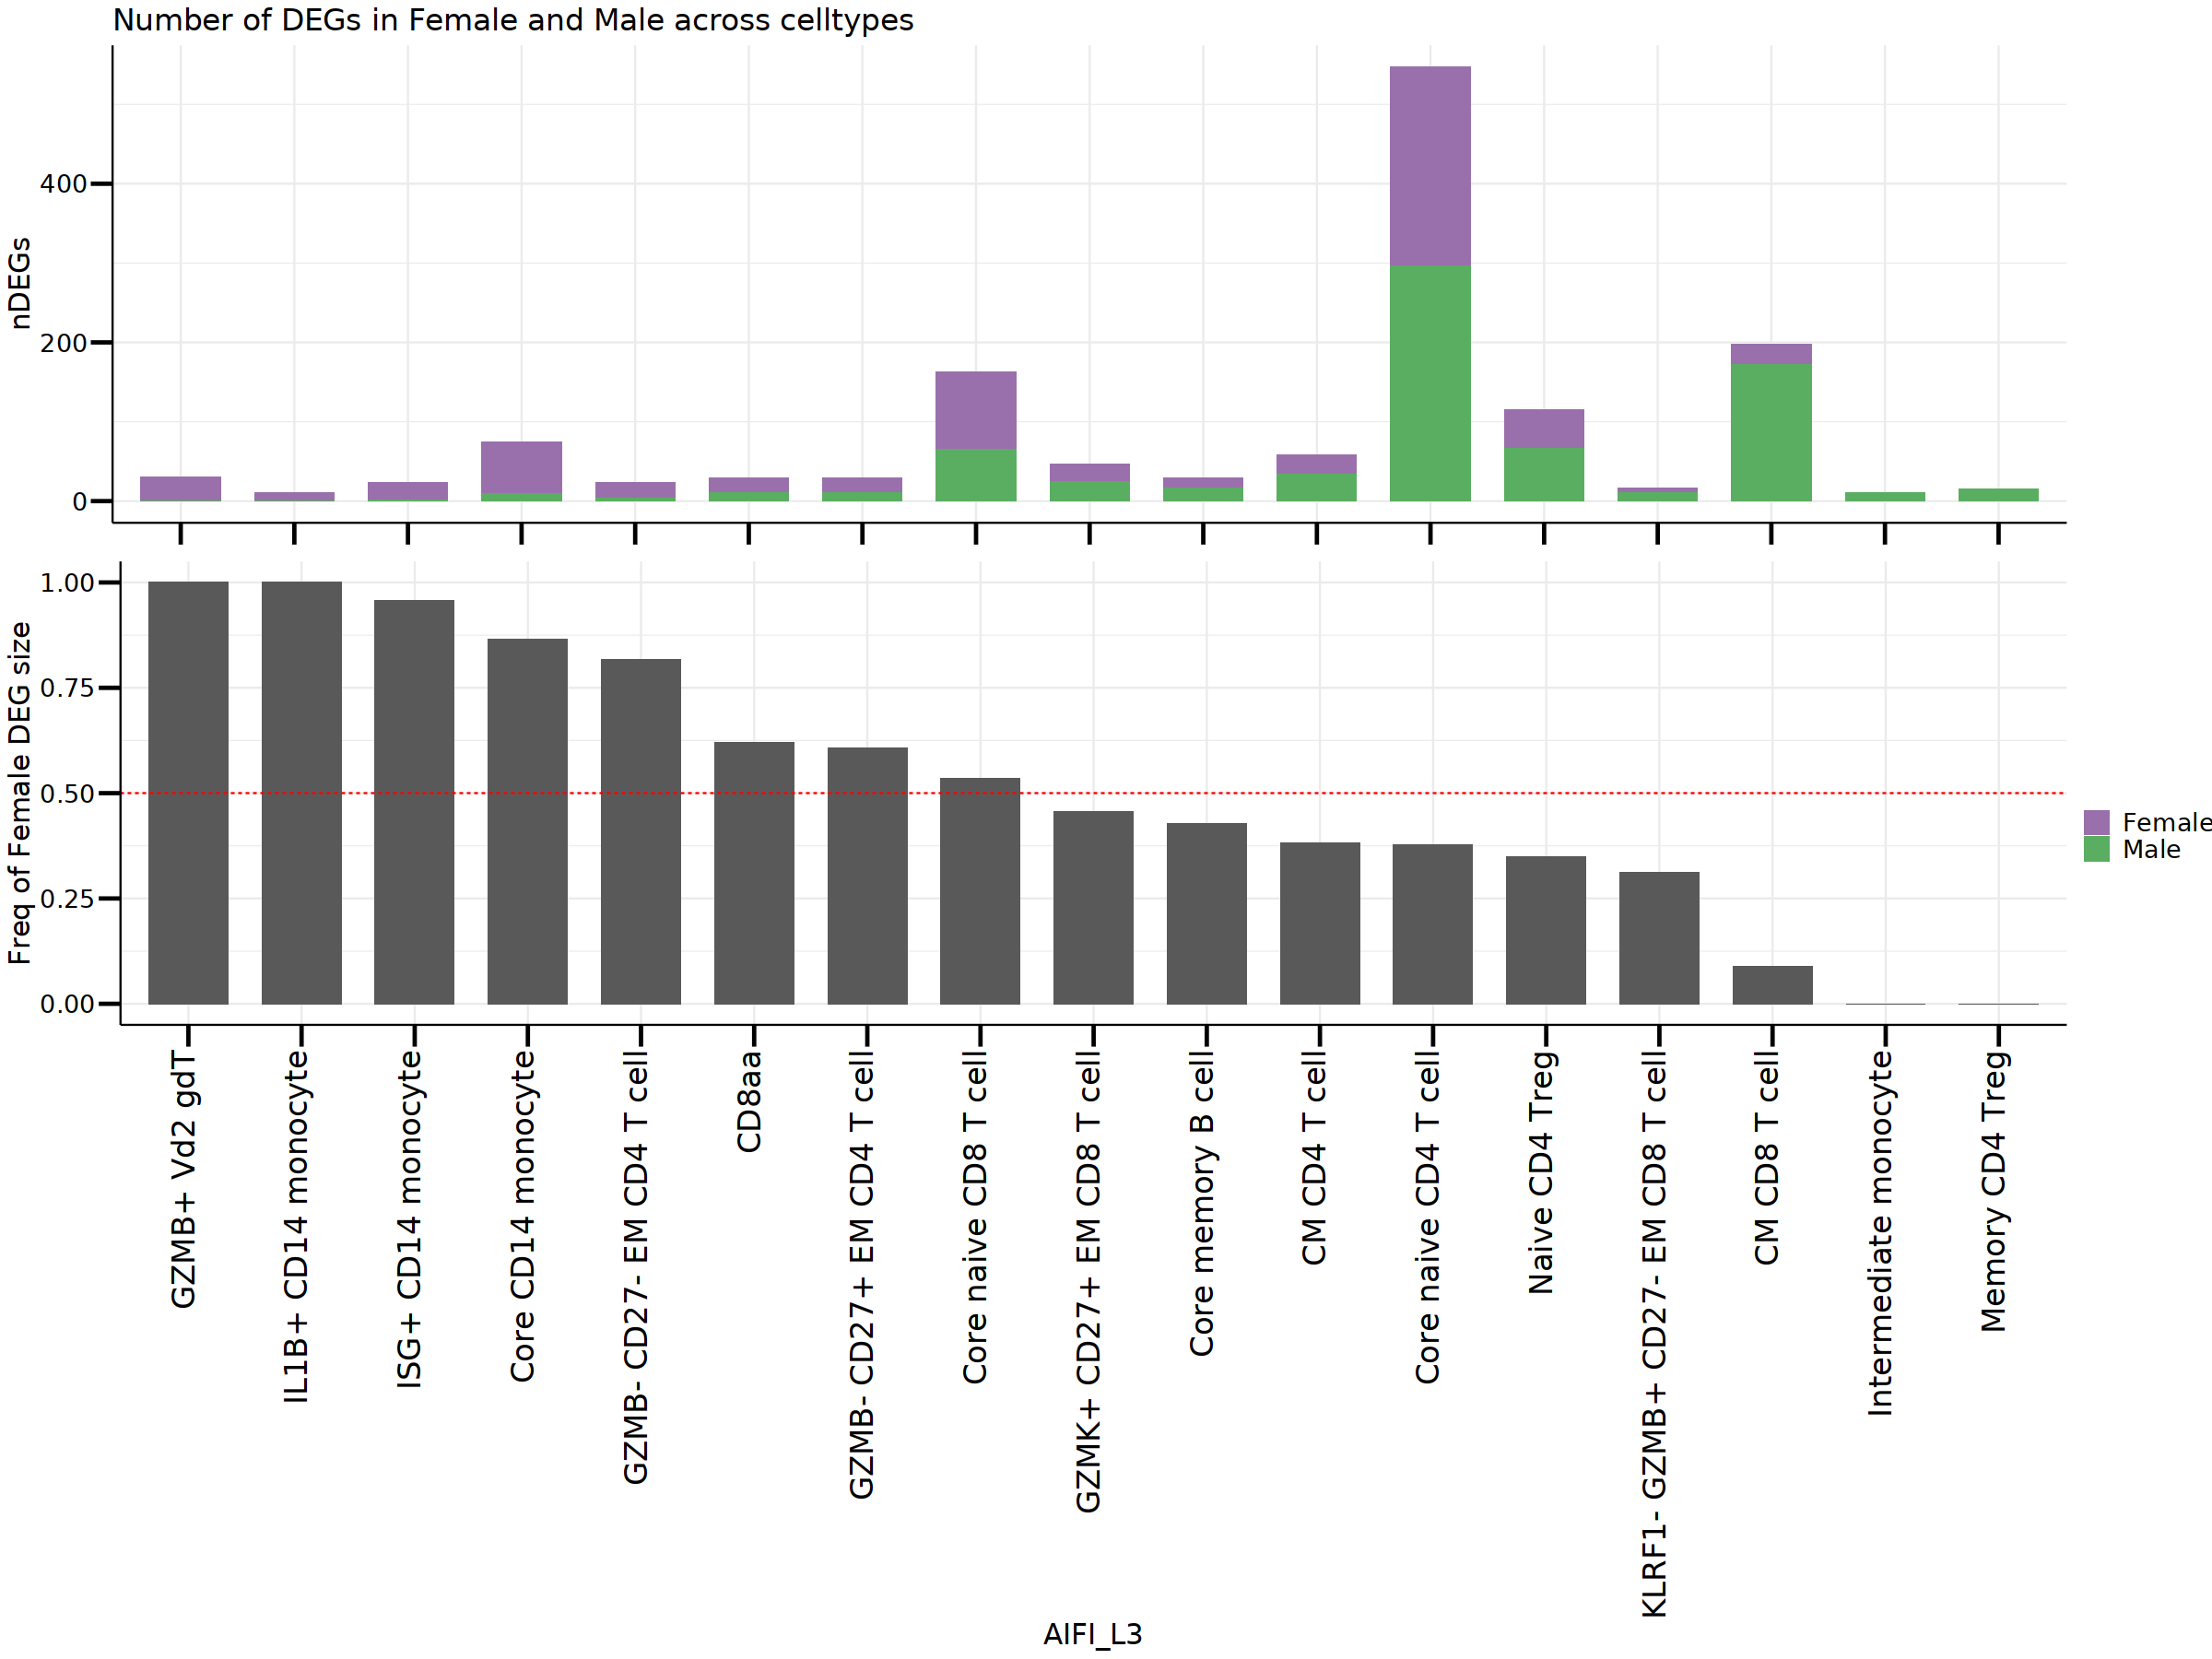

In [32]:
options(repr.plot.width = 20, repr.plot.height = 15)
ggarrange(nDEG_plot, JI_plot, nrow = 2, heights = c(1, 2), common.legend = TRUE, legend= "right")
#grid.arrange(nDEG_plot, JI_plot, ncol = 1)


# Create nDEGs plot for each celltype (p <= 0.05)

In [87]:
master <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Figure_Notebooks/Intermediate_files/master_combined_DEG_list_all_celltypes_forfigs.csv")

In [88]:
library(dplyr)
library(tidyr)

# Create all possible combinations of celltype, Direction, and type
all_combinations <- expand.grid(celltype = unique(master$celltype),
                                Direction = unique(master$Direction),
                                type = unique(master$type))

# Summarize the data
master_summary <- master %>%
  dplyr::mutate(Expression = case_when(log2FoldChange >= 0.1 & padj <= 0.05 ~ "BR2",
                                 log2FoldChange <= -0.1 & padj <= 0.05 ~ "BR1",
                                 TRUE ~ "Unchanged")) %>%
  dplyr::filter(!Expression == 'Unchanged') %>%
  dplyr::group_by(celltype, Direction, type) %>%
  dplyr::summarise(count = n(), .groups = 'drop')

# Left join with all_combinations and fill missing counts with 0
master_complete <- left_join(all_combinations, master_summary, by = c("celltype", "Direction", "type")) %>%
  dplyr::mutate(count = replace_na(count, 0)) %>% 
  filter(!is.na(Direction)) # Remove rows with NA in the Direction column



# Check the number of unique celltypes
length(unique(master_complete$celltype))


head(master_complete)
#all_combinations

[1] 71

,celltype,Direction,type,count
,<chr>,<chr>,<chr>,<int>
1,Activated memory B cell,BR1,DEGs_Male,0
2,Adaptive NK cell,BR1,DEGs_Male,0
3,ASDC,BR1,DEGs_Male,0
4,BaEoMaP cell,BR1,DEGs_Male,0
5,C1Q+ CD16 monocyte,BR1,DEGs_Male,0
6,CD14+ cDC2,BR1,DEGs_Male,0


In [89]:
master_complete_1 <- master_complete %>% filter(celltype == "ASDC")
master_complete_1

celltype,Direction,type,count
<chr>,<chr>,<chr>,<int>
ASDC,BR1,DEGs_Male,0
ASDC,BR2,DEGs_Male,0
ASDC,BR1,DEGs_Female,0
ASDC,BR2,DEGs_Female,0


In [92]:
## old method
library(dplyr)
library(tidyr)

master<- master%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.05 ~ "BR2",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "BR1",
                                                     TRUE ~ "Unchanged"))

master<-master %>% filter(Year=='Y1')



master_2 <- master %>%
  dplyr::mutate(Expression = case_when(log2FoldChange >= 0.1 & padj <=0.05 ~ "BR2",
                                 log2FoldChange <= -0.1 & padj <= 0.05~ "BR1",
                                 TRUE ~ "Unchanged")) %>%
  dplyr::filter(!Expression == 'Unchanged') %>%
  dplyr::group_by(celltype, Direction, type) %>%
  dplyr::summarise(count = n(), .groups = 'drop') %>%
  tidyr::complete(celltype, Direction, type, fill = list(count = 0)) # Add missing combinations and fill with 0 

head(master_2) 
length(unique(master_2$celltype))  ## Only 38/71 celltypes had significant DEGs (p<=0.1)

celltype,Direction,type,count
<chr>,<chr>,<chr>,<int>
CD27- effector B cell,BR1,DEGs_Female,2
CD27- effector B cell,BR1,DEGs_Male,0
CD27- effector B cell,BR2,DEGs_Female,0
CD27- effector B cell,BR2,DEGs_Male,0
CD27+ effector B cell,BR1,DEGs_Female,0
CD27+ effector B cell,BR1,DEGs_Male,0


[1] 32

In [3]:
## stacked plot of nDEG counts

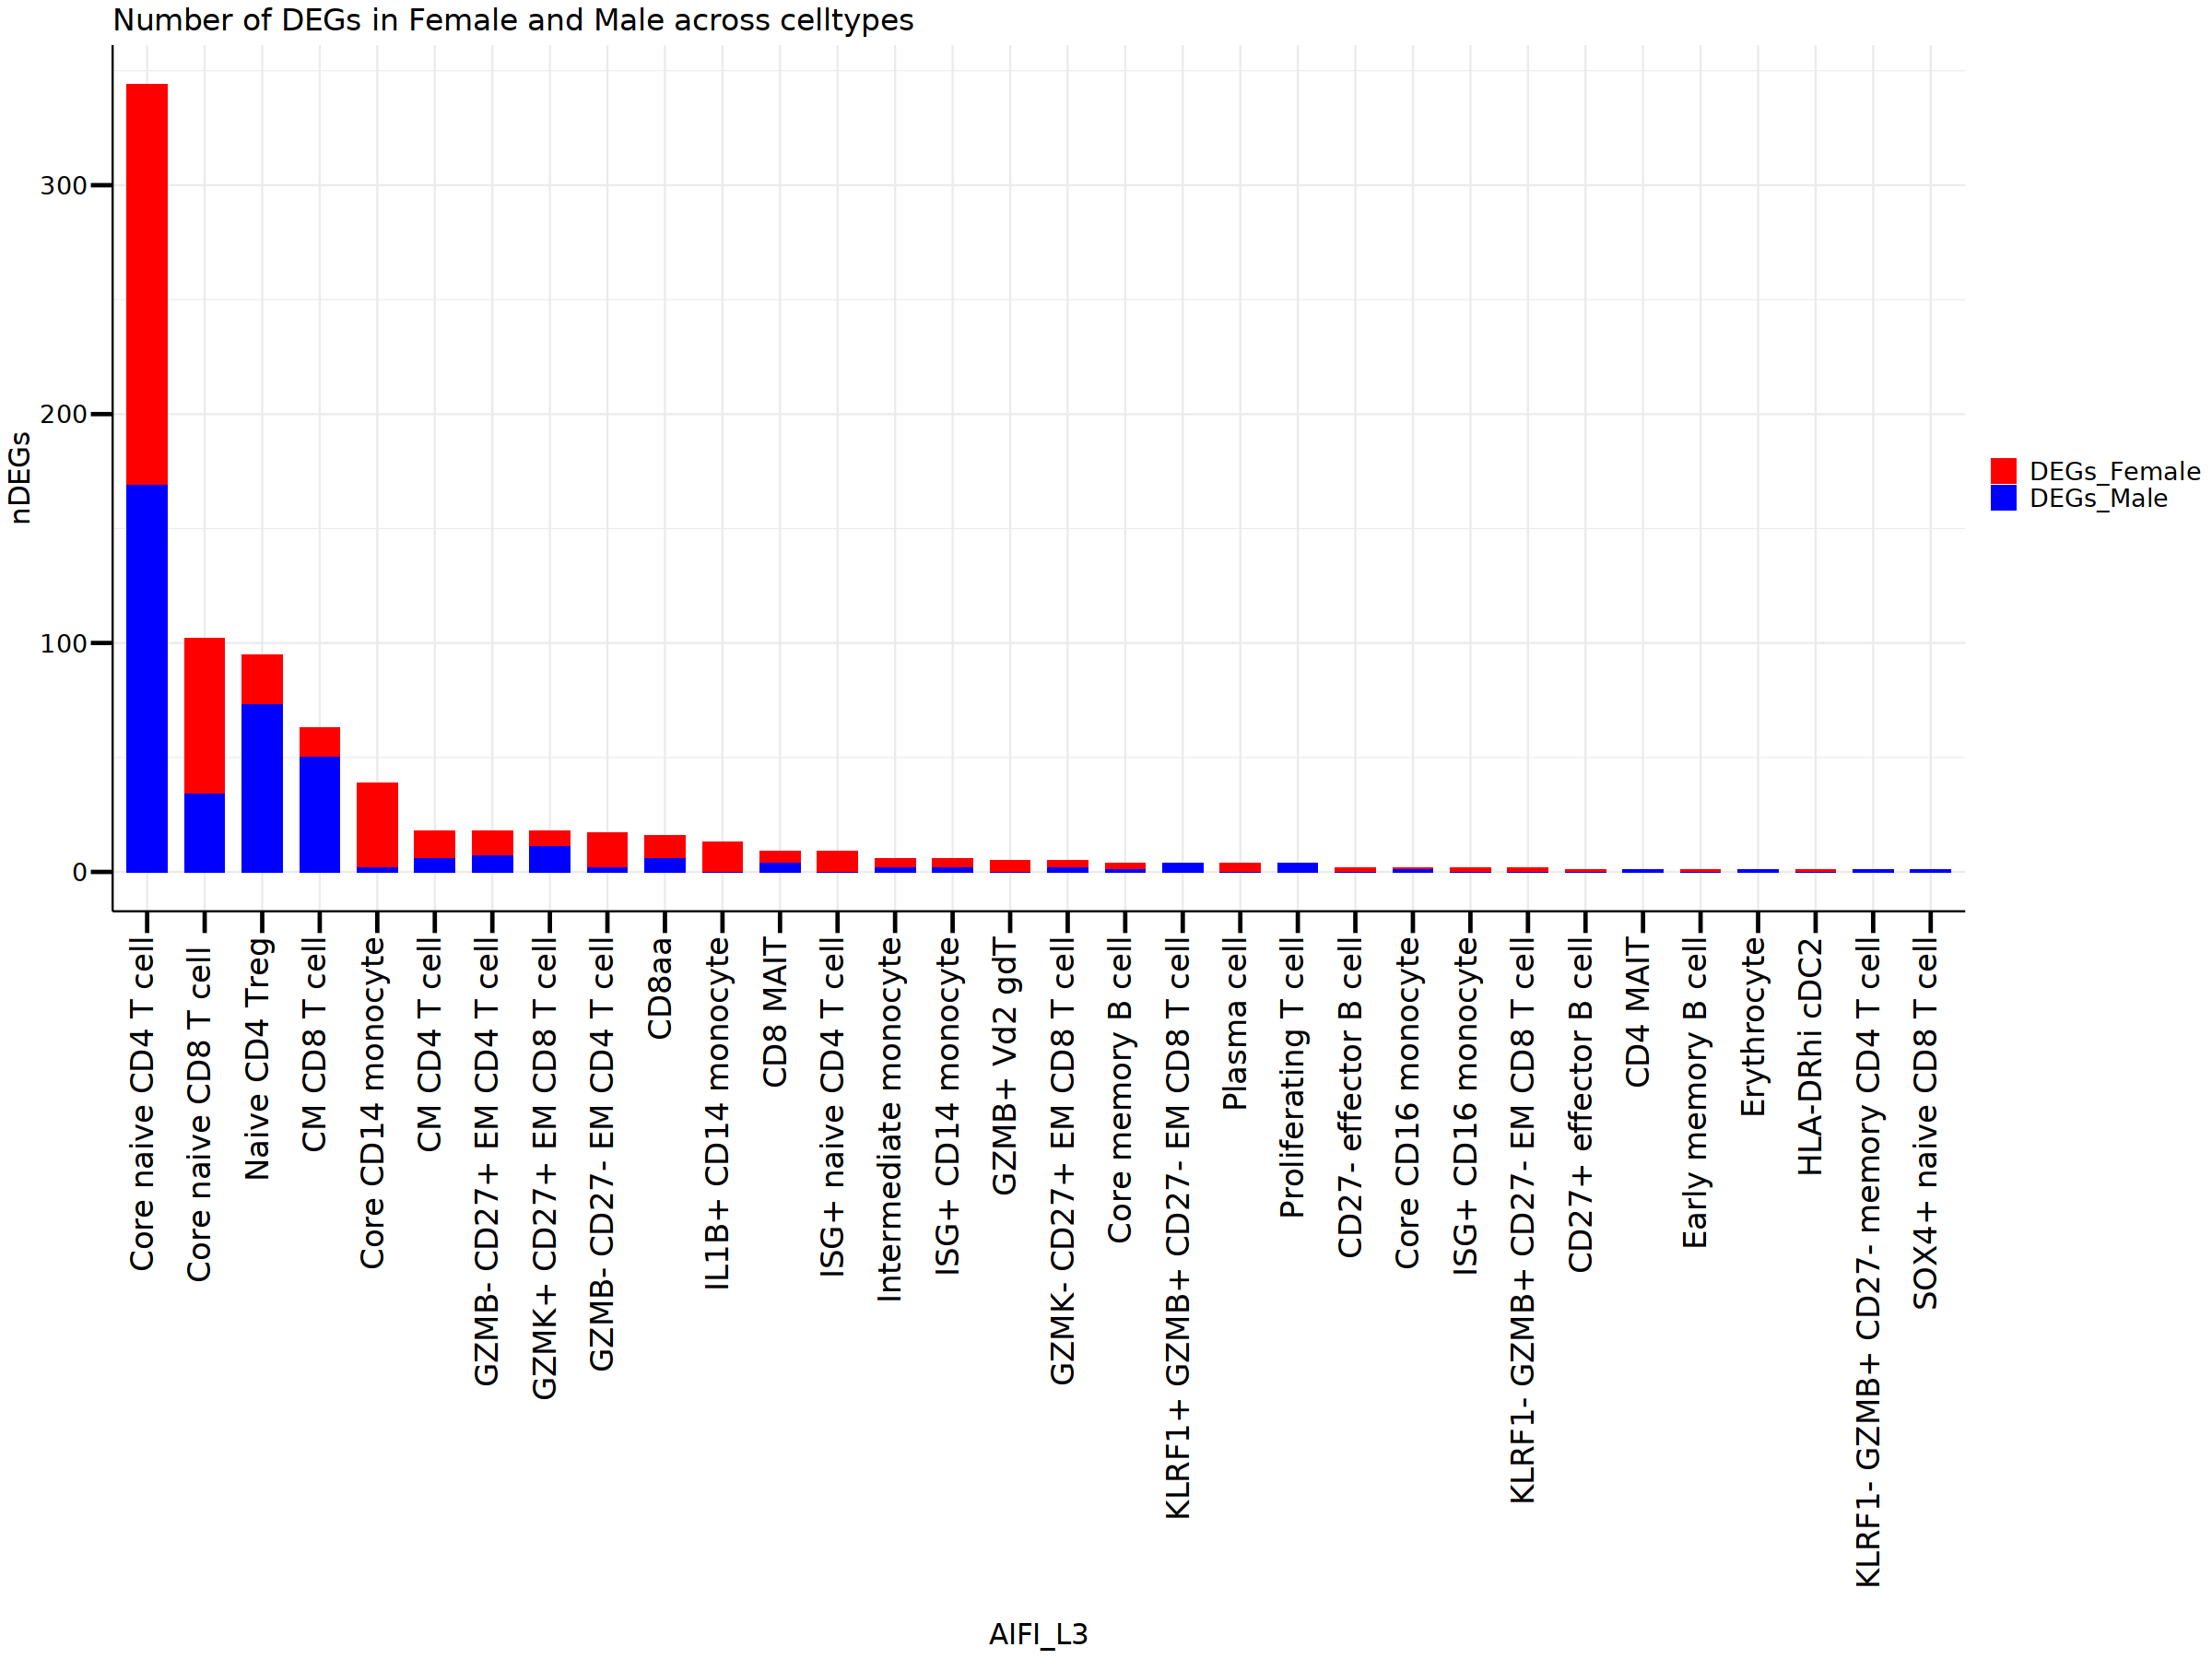

In [93]:
pastel_colors <- c( "red", "blue" )  # Example pastel colors


options(repr.plot.width = 20, repr.plot.height = 15)

ggplot(master_2, aes(x = reorder(celltype, desc(count)), y = count, fill = type)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_fill_manual(values = pastel_colors) +  # Set pastel colors
  labs(title = "Number of DEGs in Female and Male across celltypes", x = "\nAIFI_L3", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  ) 

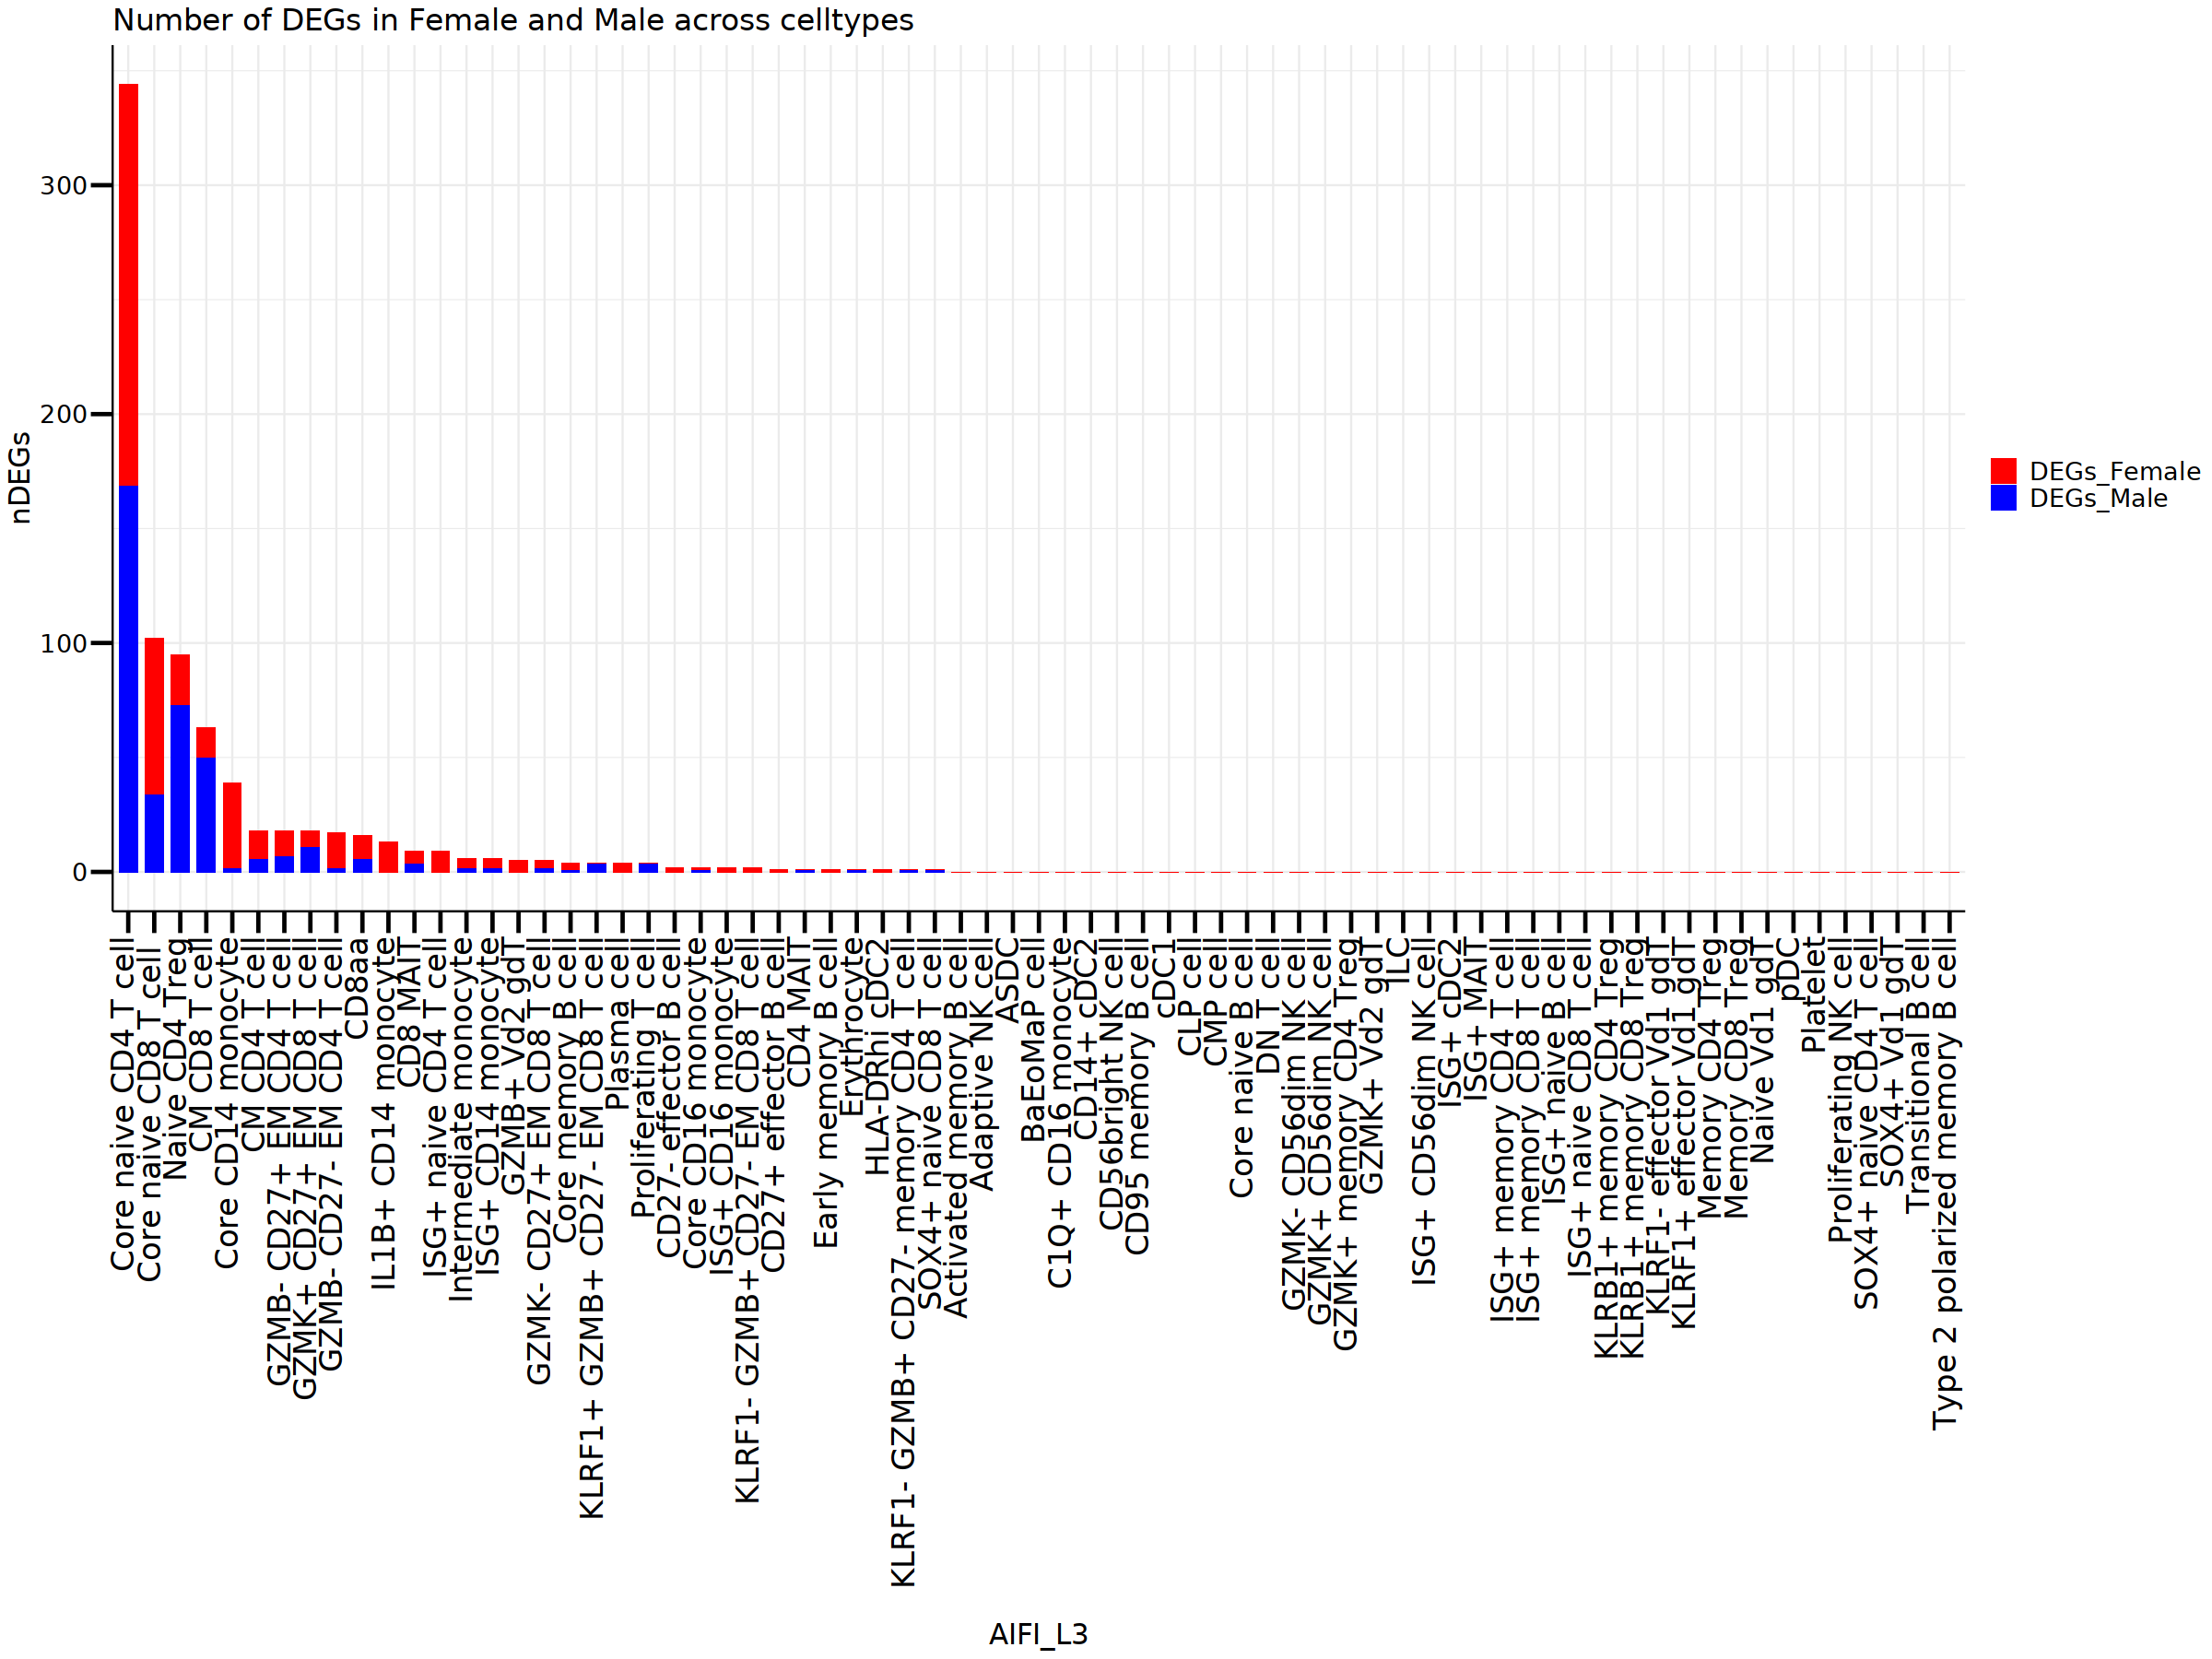

In [94]:
pastel_colors <- c( "red", "blue" )  # Example pastel colors


options(repr.plot.width = 20, repr.plot.height = 15)

ggplot(master_complete, aes(x = reorder(celltype, desc(count)), y = count, fill = type)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_fill_manual(values = pastel_colors) +  # Set pastel colors
  labs(title = "Number of DEGs in Female and Male across celltypes", x = "\nAIFI_L3", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  ) 

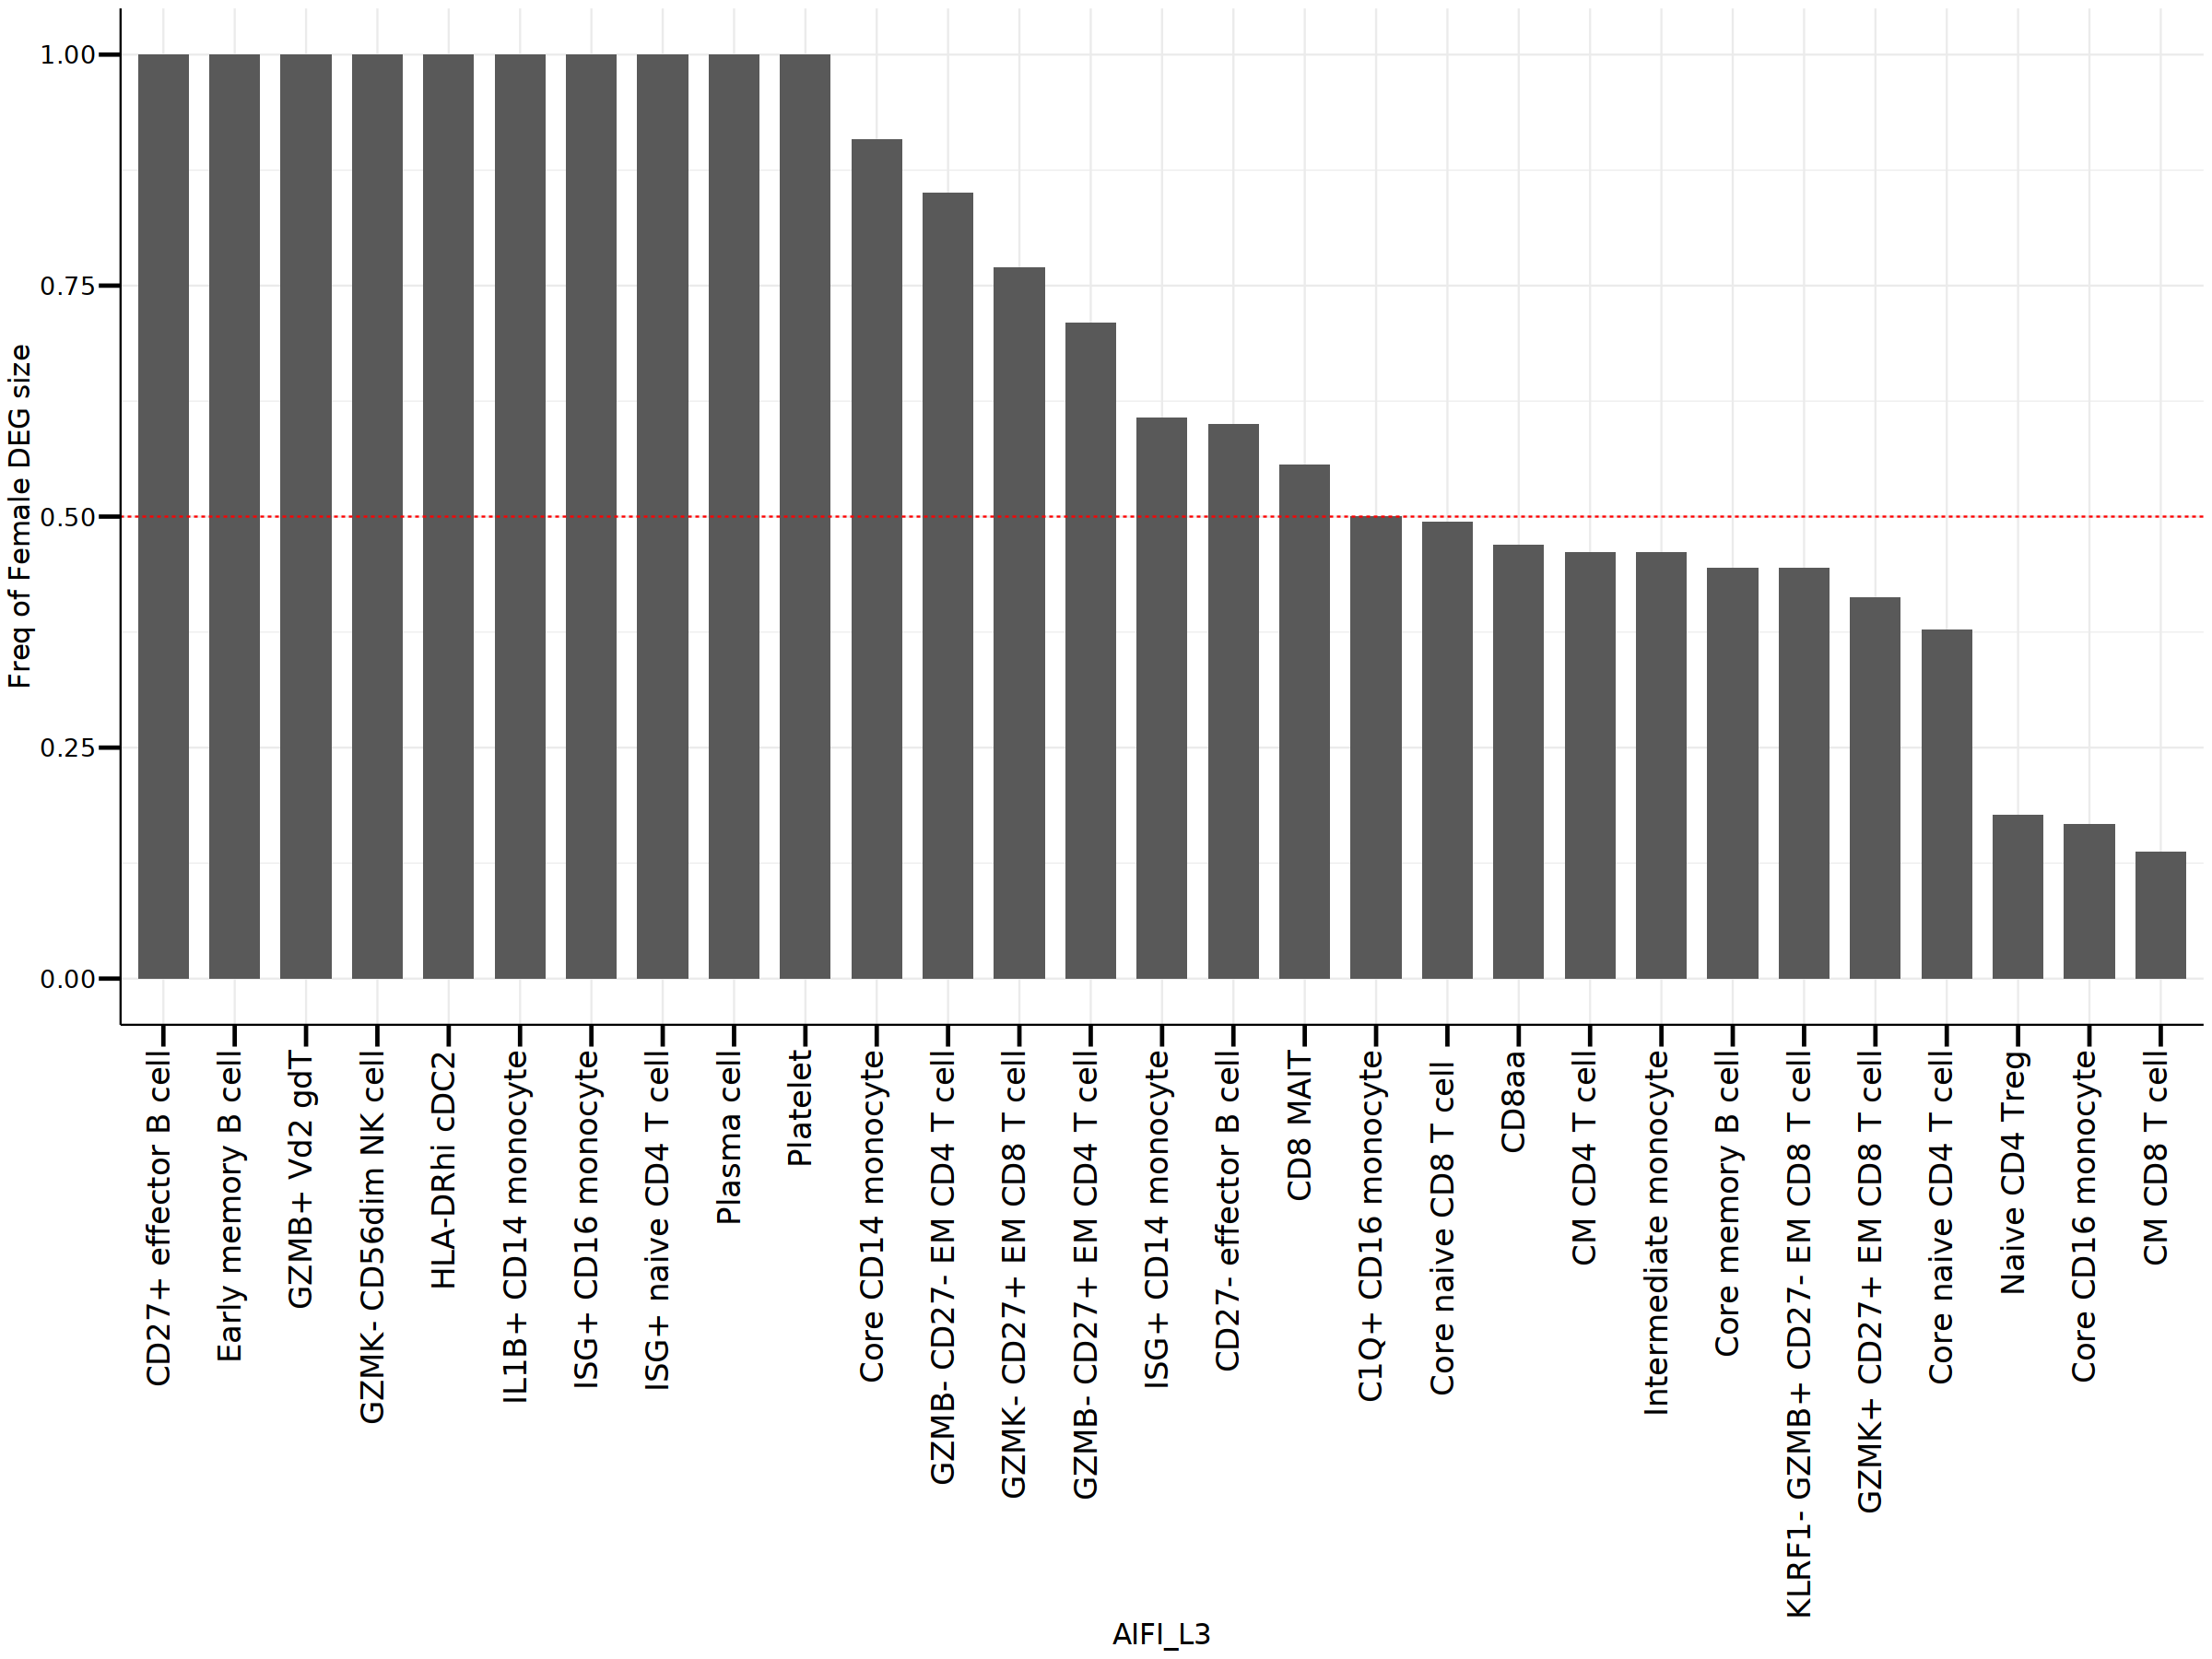

In [186]:
library(ggplot2)

# Assuming your dataframe is named df
# Replace df with the actual name of your dataframe if different

# Sort dataframe by Data_y in descending order
new_JI <- new_JI[order(-new_JI$Unique_F_ratio),]

# Convert cell_type to factor with levels arranged in descending order
new_JI$celltype <- factor(new_JI$celltype, levels = new_JI$celltype)

#options(repr.plot.width = 20, repr.plot.height = 10)
# Create JI plot
JI_plot <- ggplot(new_JI, aes(x = celltype, y = Unique_F_ratio)) +
  geom_bar(stat = "identity", width = 0.7) +
  #geom_segment(aes(x = celltype, xend = celltype, y = 0, yend = Unique_F_ratio), color = "skyblue") +
  #geom_point(color = "blue", size = 3) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red")+
  theme_minimal() + 
  #coord_flip() + 
  labs(x = "AIFI_L3", y = "Freq of Female DEG size") +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  )   

# Print the plot
#print(JI_plot)




pastel_colors <- c( "red", "blue" )  # Example pastel colors

#celltype order from the JI plot
master_complete$celltype <- factor(master_complete$celltype, levels = celltype_order)
#reorder(celltype, desc(count))
#options(repr.plot.width = 20, repr.plot.height = 5)

nDEG_plot <- ggplot(master_complete, aes(x = celltype, y = count, fill = type)) +
  geom_bar(stat = "identity", width = 0.7) +
  scale_fill_manual(values = pastel_colors) +  # Set pastel colors
  labs(title = "Number of DEGs in Female and Male across celltypes", x = "\nAIFI_L3", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  ) +
  theme(axis.title.x = element_blank(), axis.text.x = element_blank()) + theme(legend.position = "none")

#nDEG_plot



options(repr.plot.width = 20, repr.plot.height = 15)
ggarrange(nDEG_plot, JI_plot, nrow = 2, heights = c(1, 2), align = "v", common.legend = TRUE, legend= "right")


# Stack the nDEG and JI rato plot together

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


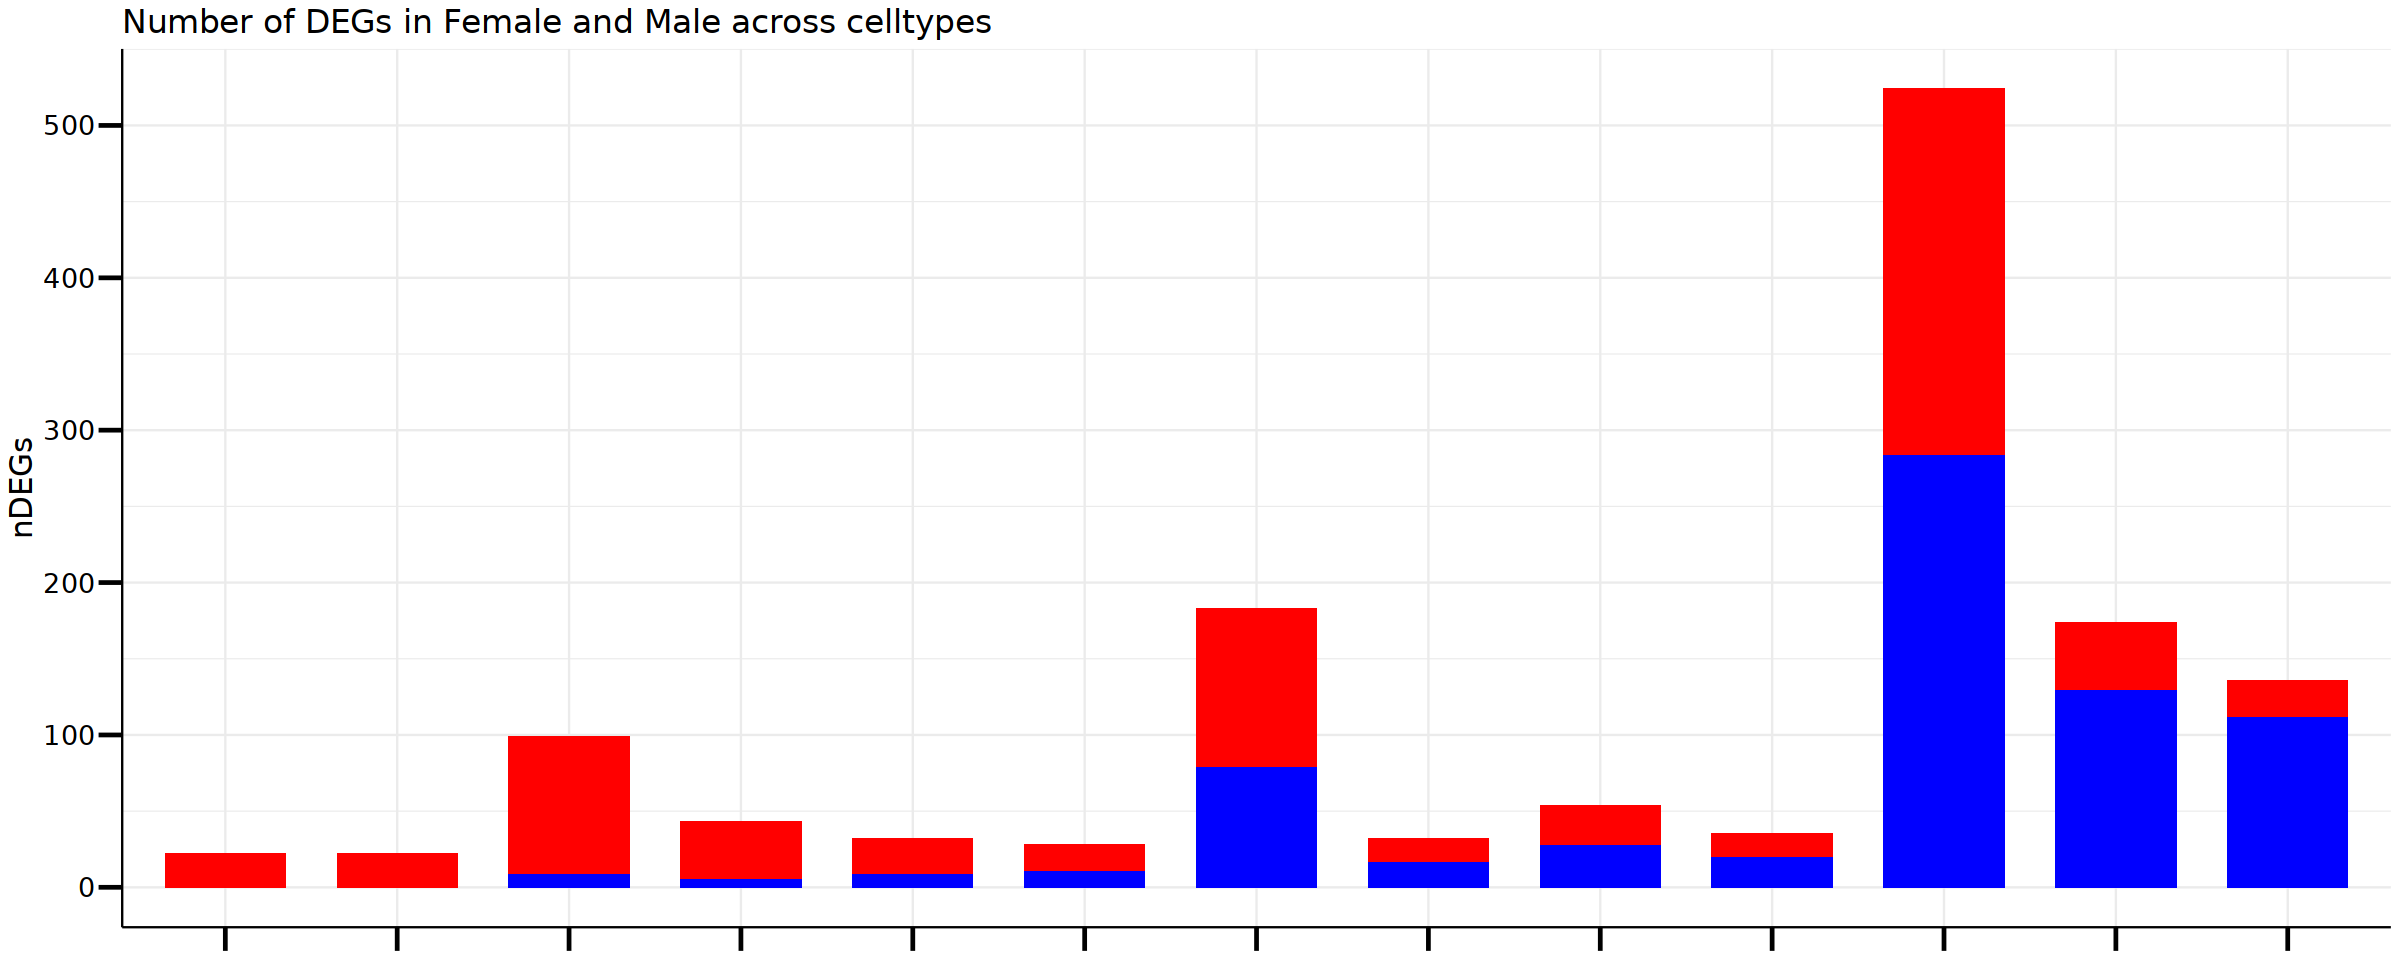

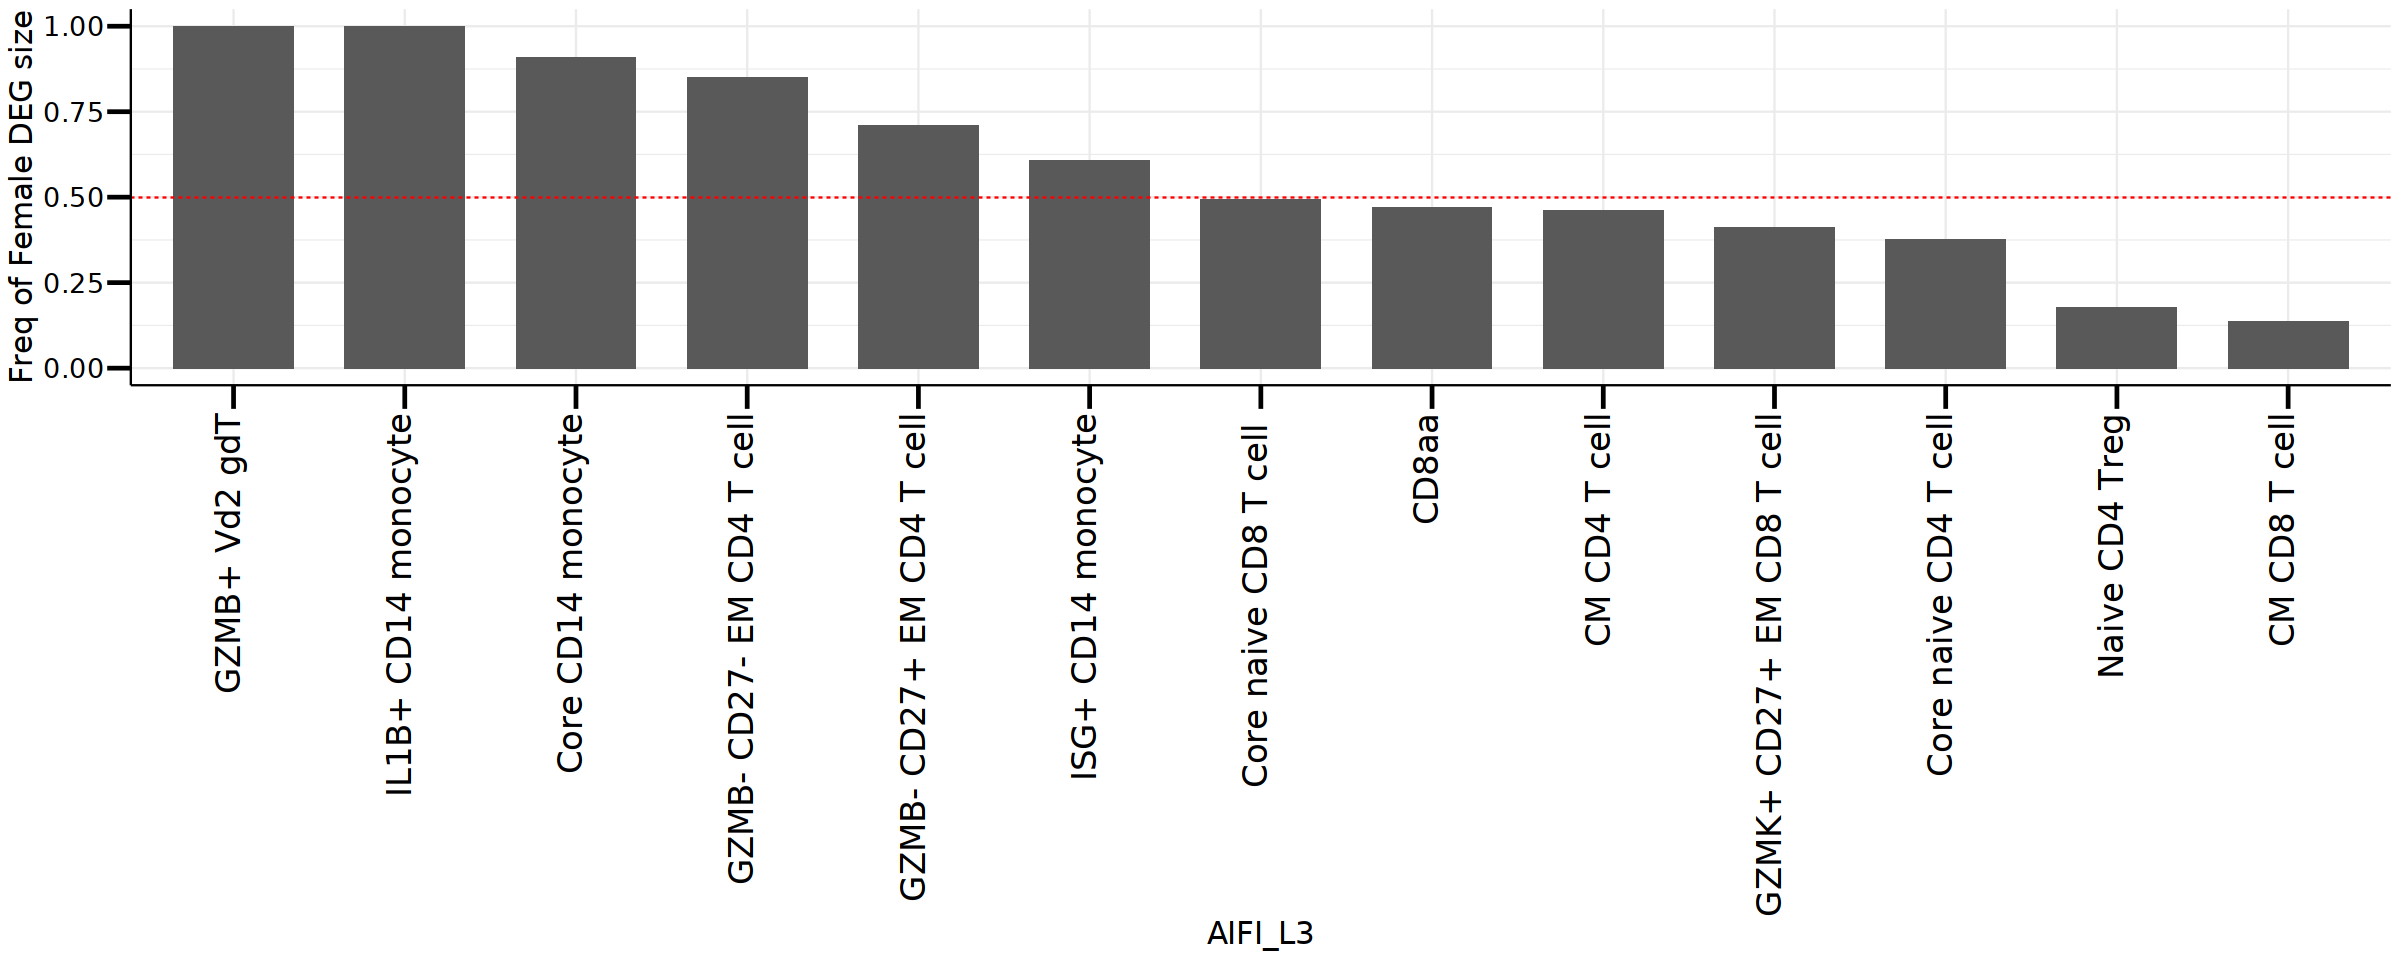

In [77]:
options(repr.plot.width = 20, repr.plot.height = 8)

# Set the same x-axis limits for both plots
x_limits <- c(1, length(celltype_order))

# Print the plots

print(nDEG_plot + coord_cartesian(xlim = x_limits))
print(JI_plot + coord_cartesian(xlim = x_limits))



In [54]:
library(ggpubr)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




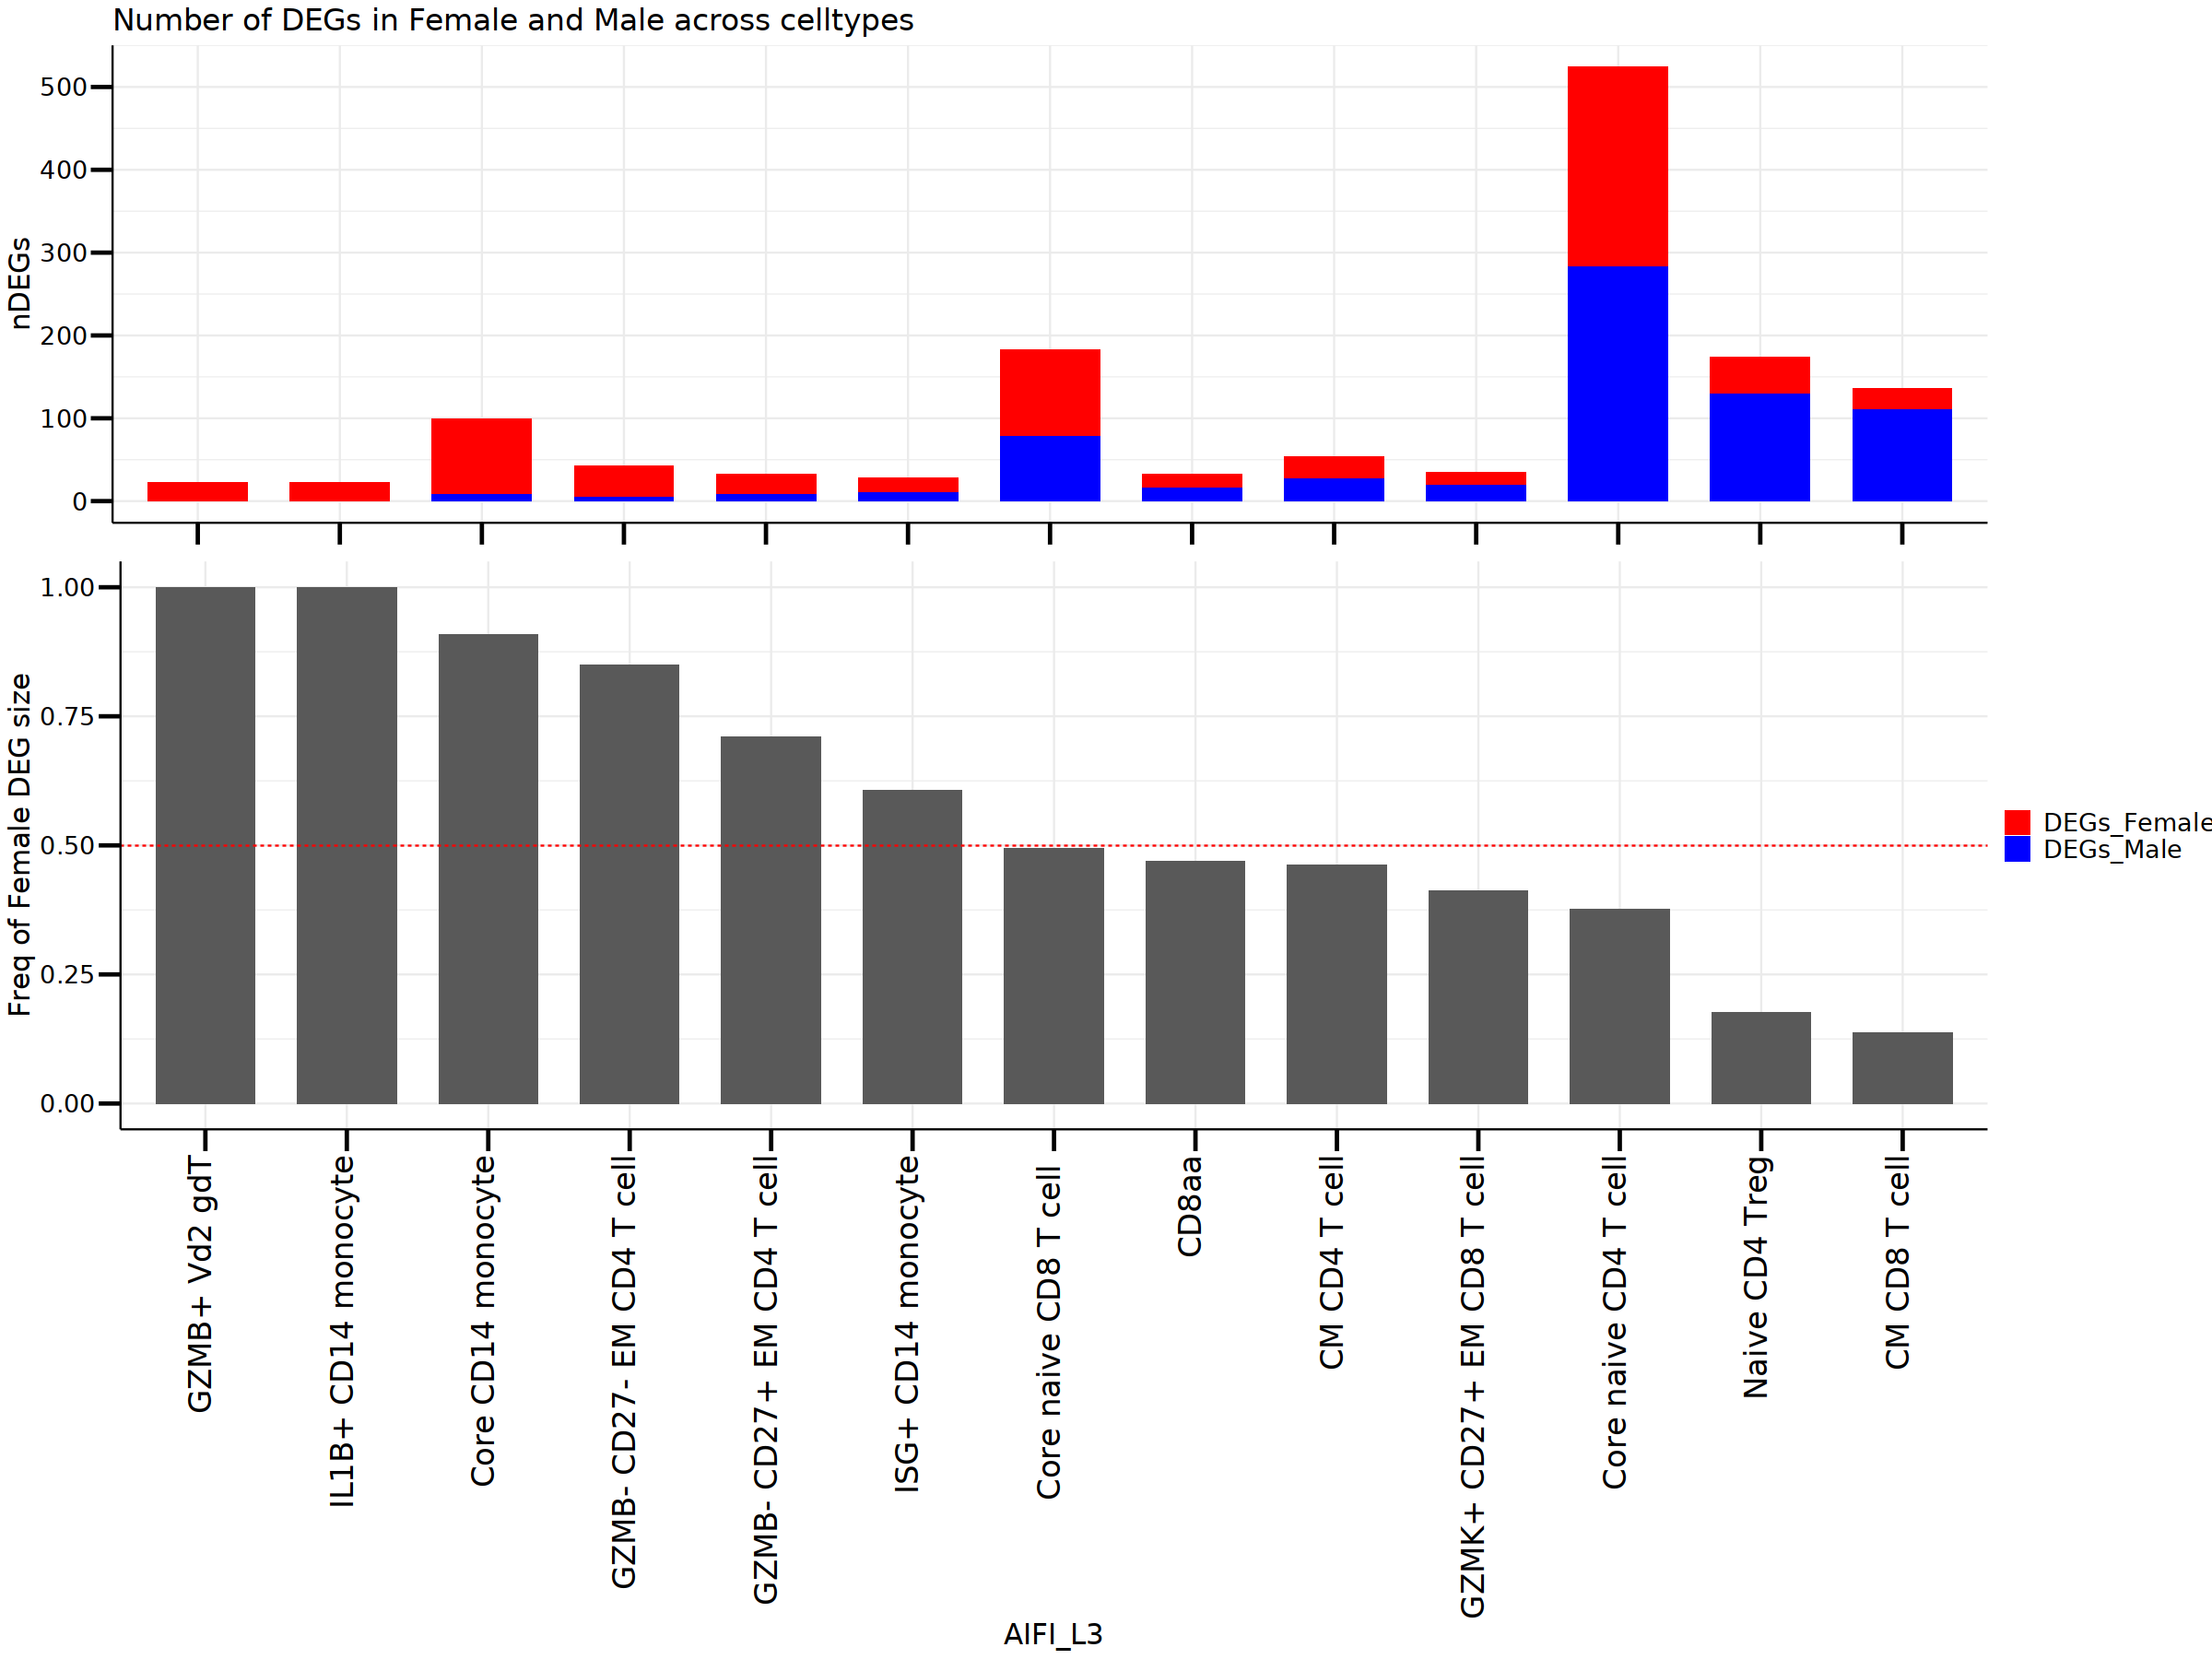

In [83]:
options(repr.plot.width = 20, repr.plot.height = 15)
ggarrange(nDEG_plot, JI_plot, nrow = 2, heights = c(1, 2), common.legend = TRUE, legend= "right")
#grid.arrange(nDEG_plot, JI_plot, ncol = 1)


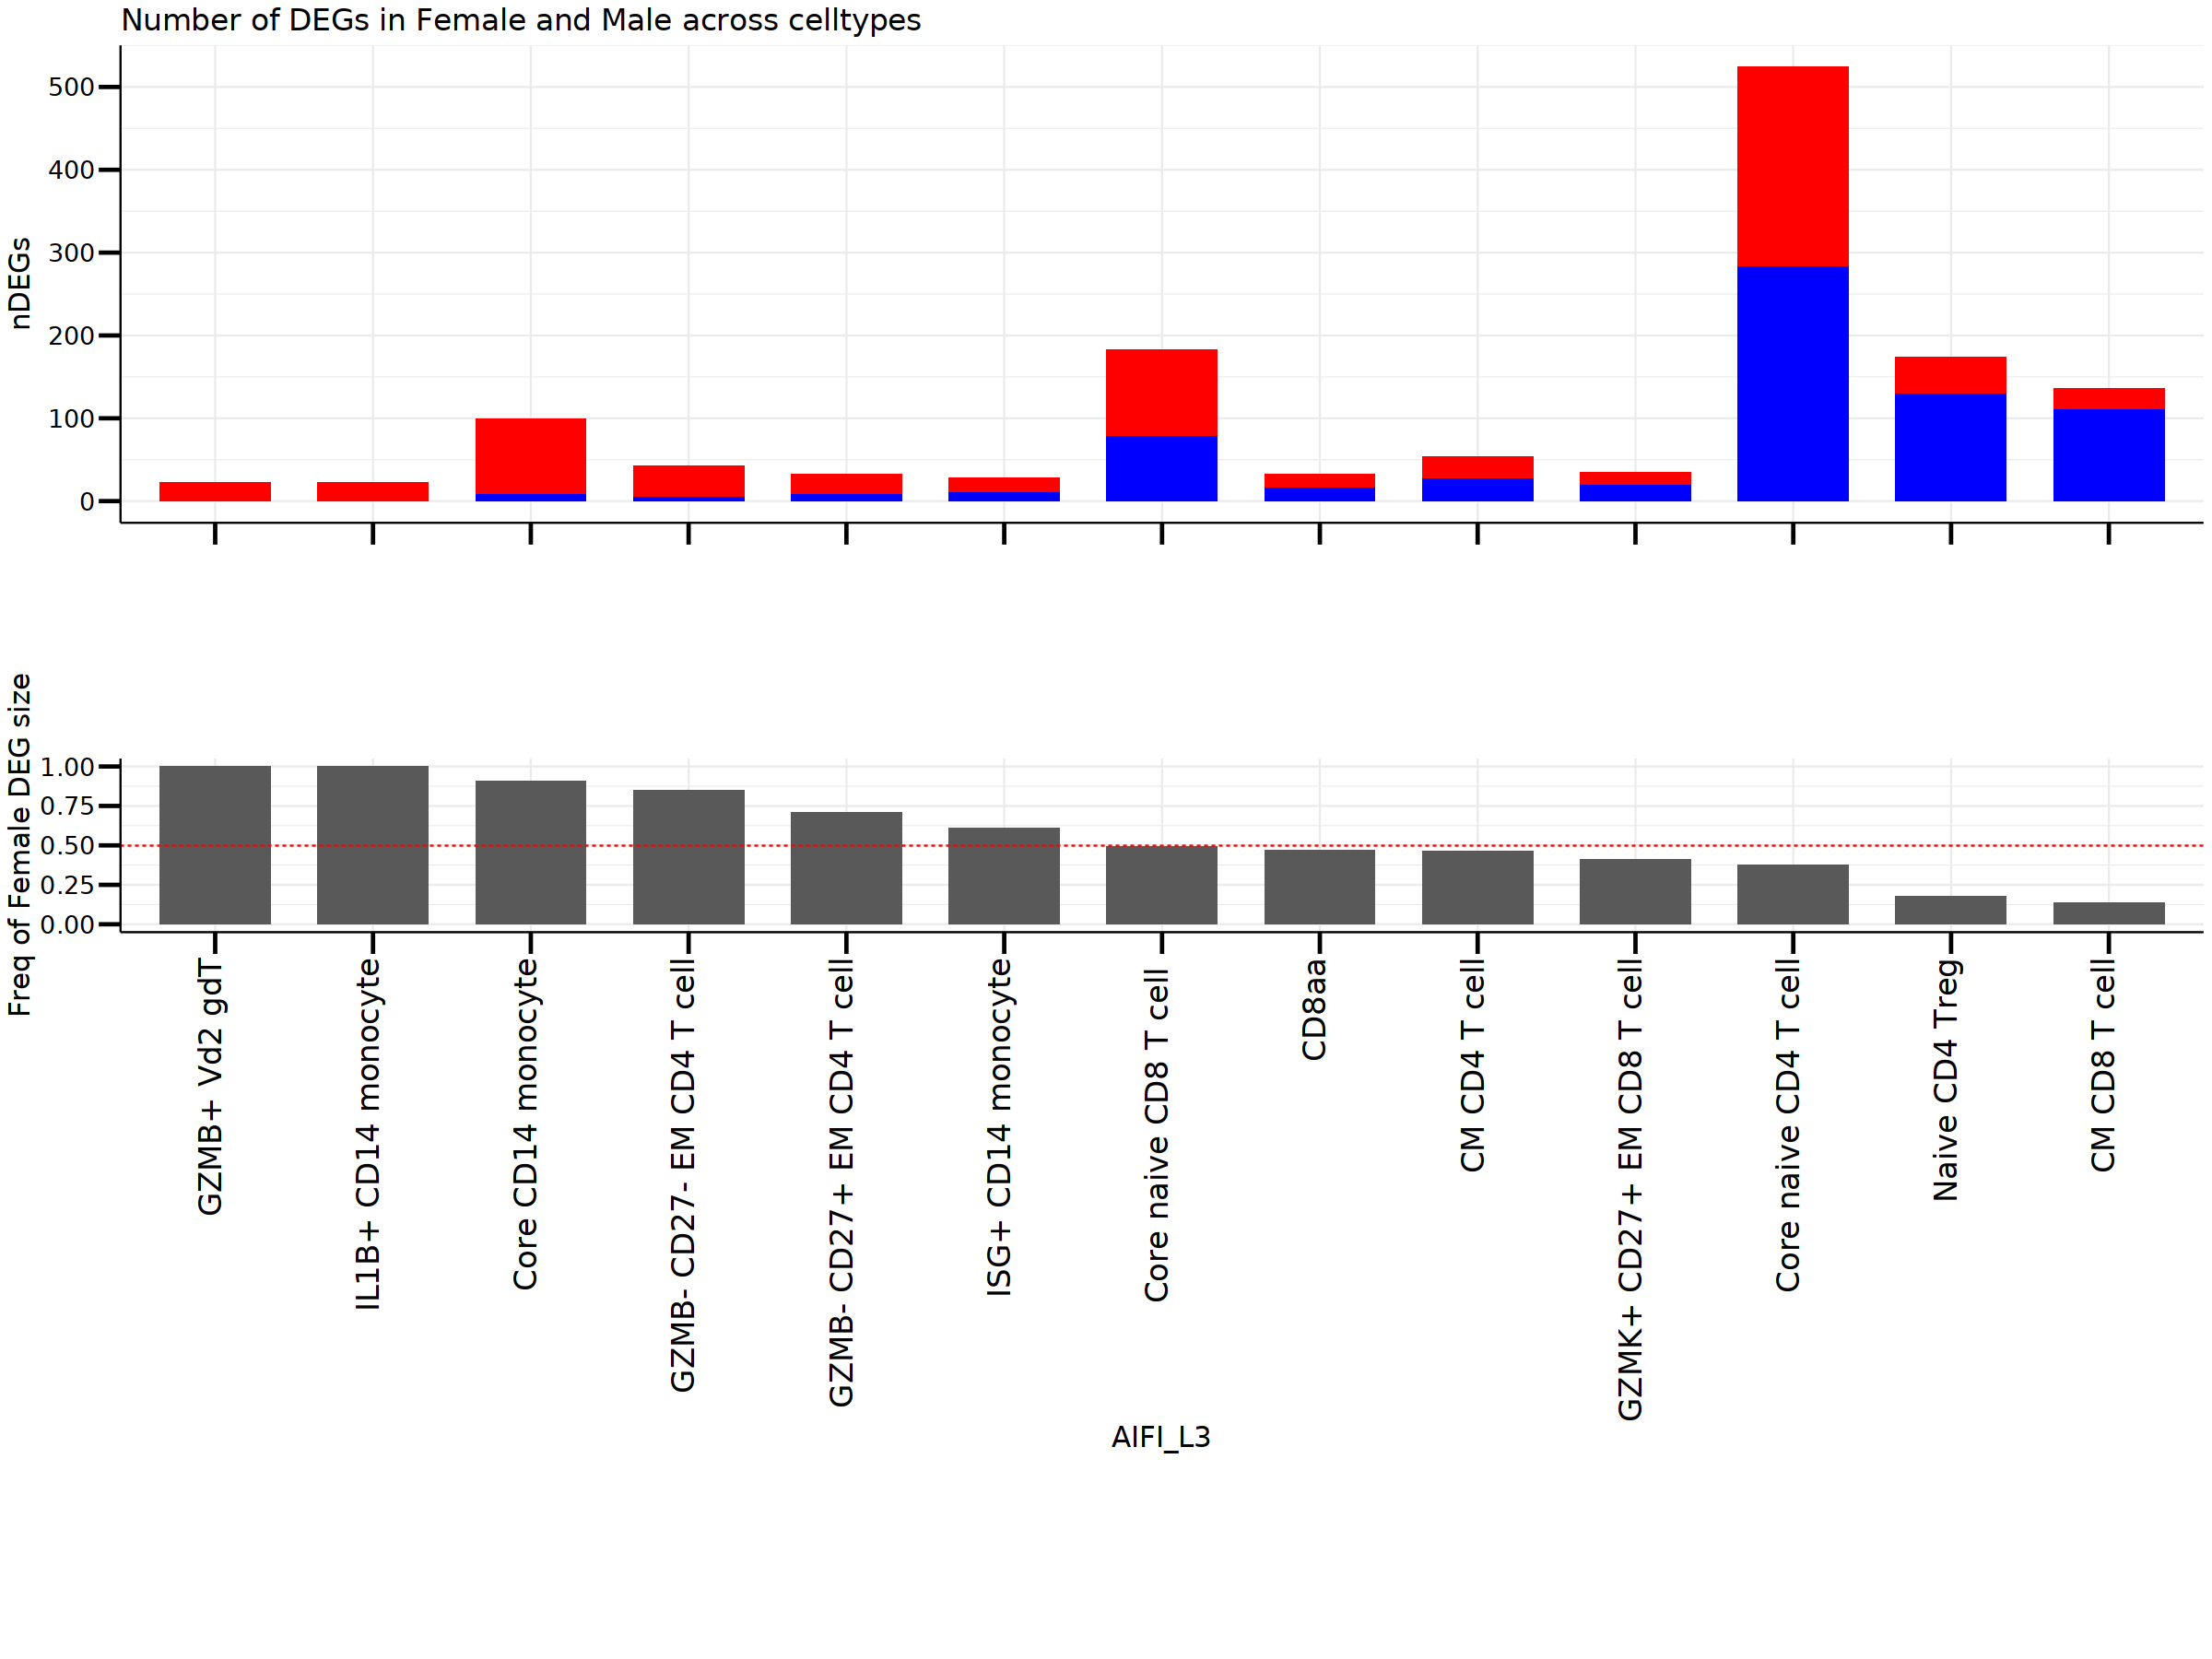

In [76]:
library(cowplot)

# Create the plots separately
plot1 <- nDEG_plot
plot2 <- JI_plot

# Combine the plots into a single grid
combined_plot <- plot_grid(plot1, plot2, nrow = 2, align = "v", rel_heights = c(1, 2))

# Print the combined plot
print(combined_plot)


Warning message in as_grob.default(plot):
“Cannot convert object of class logical into a grob.”
Warning message in as_grob.default(plot):
“Cannot convert object of class character into a grob.”


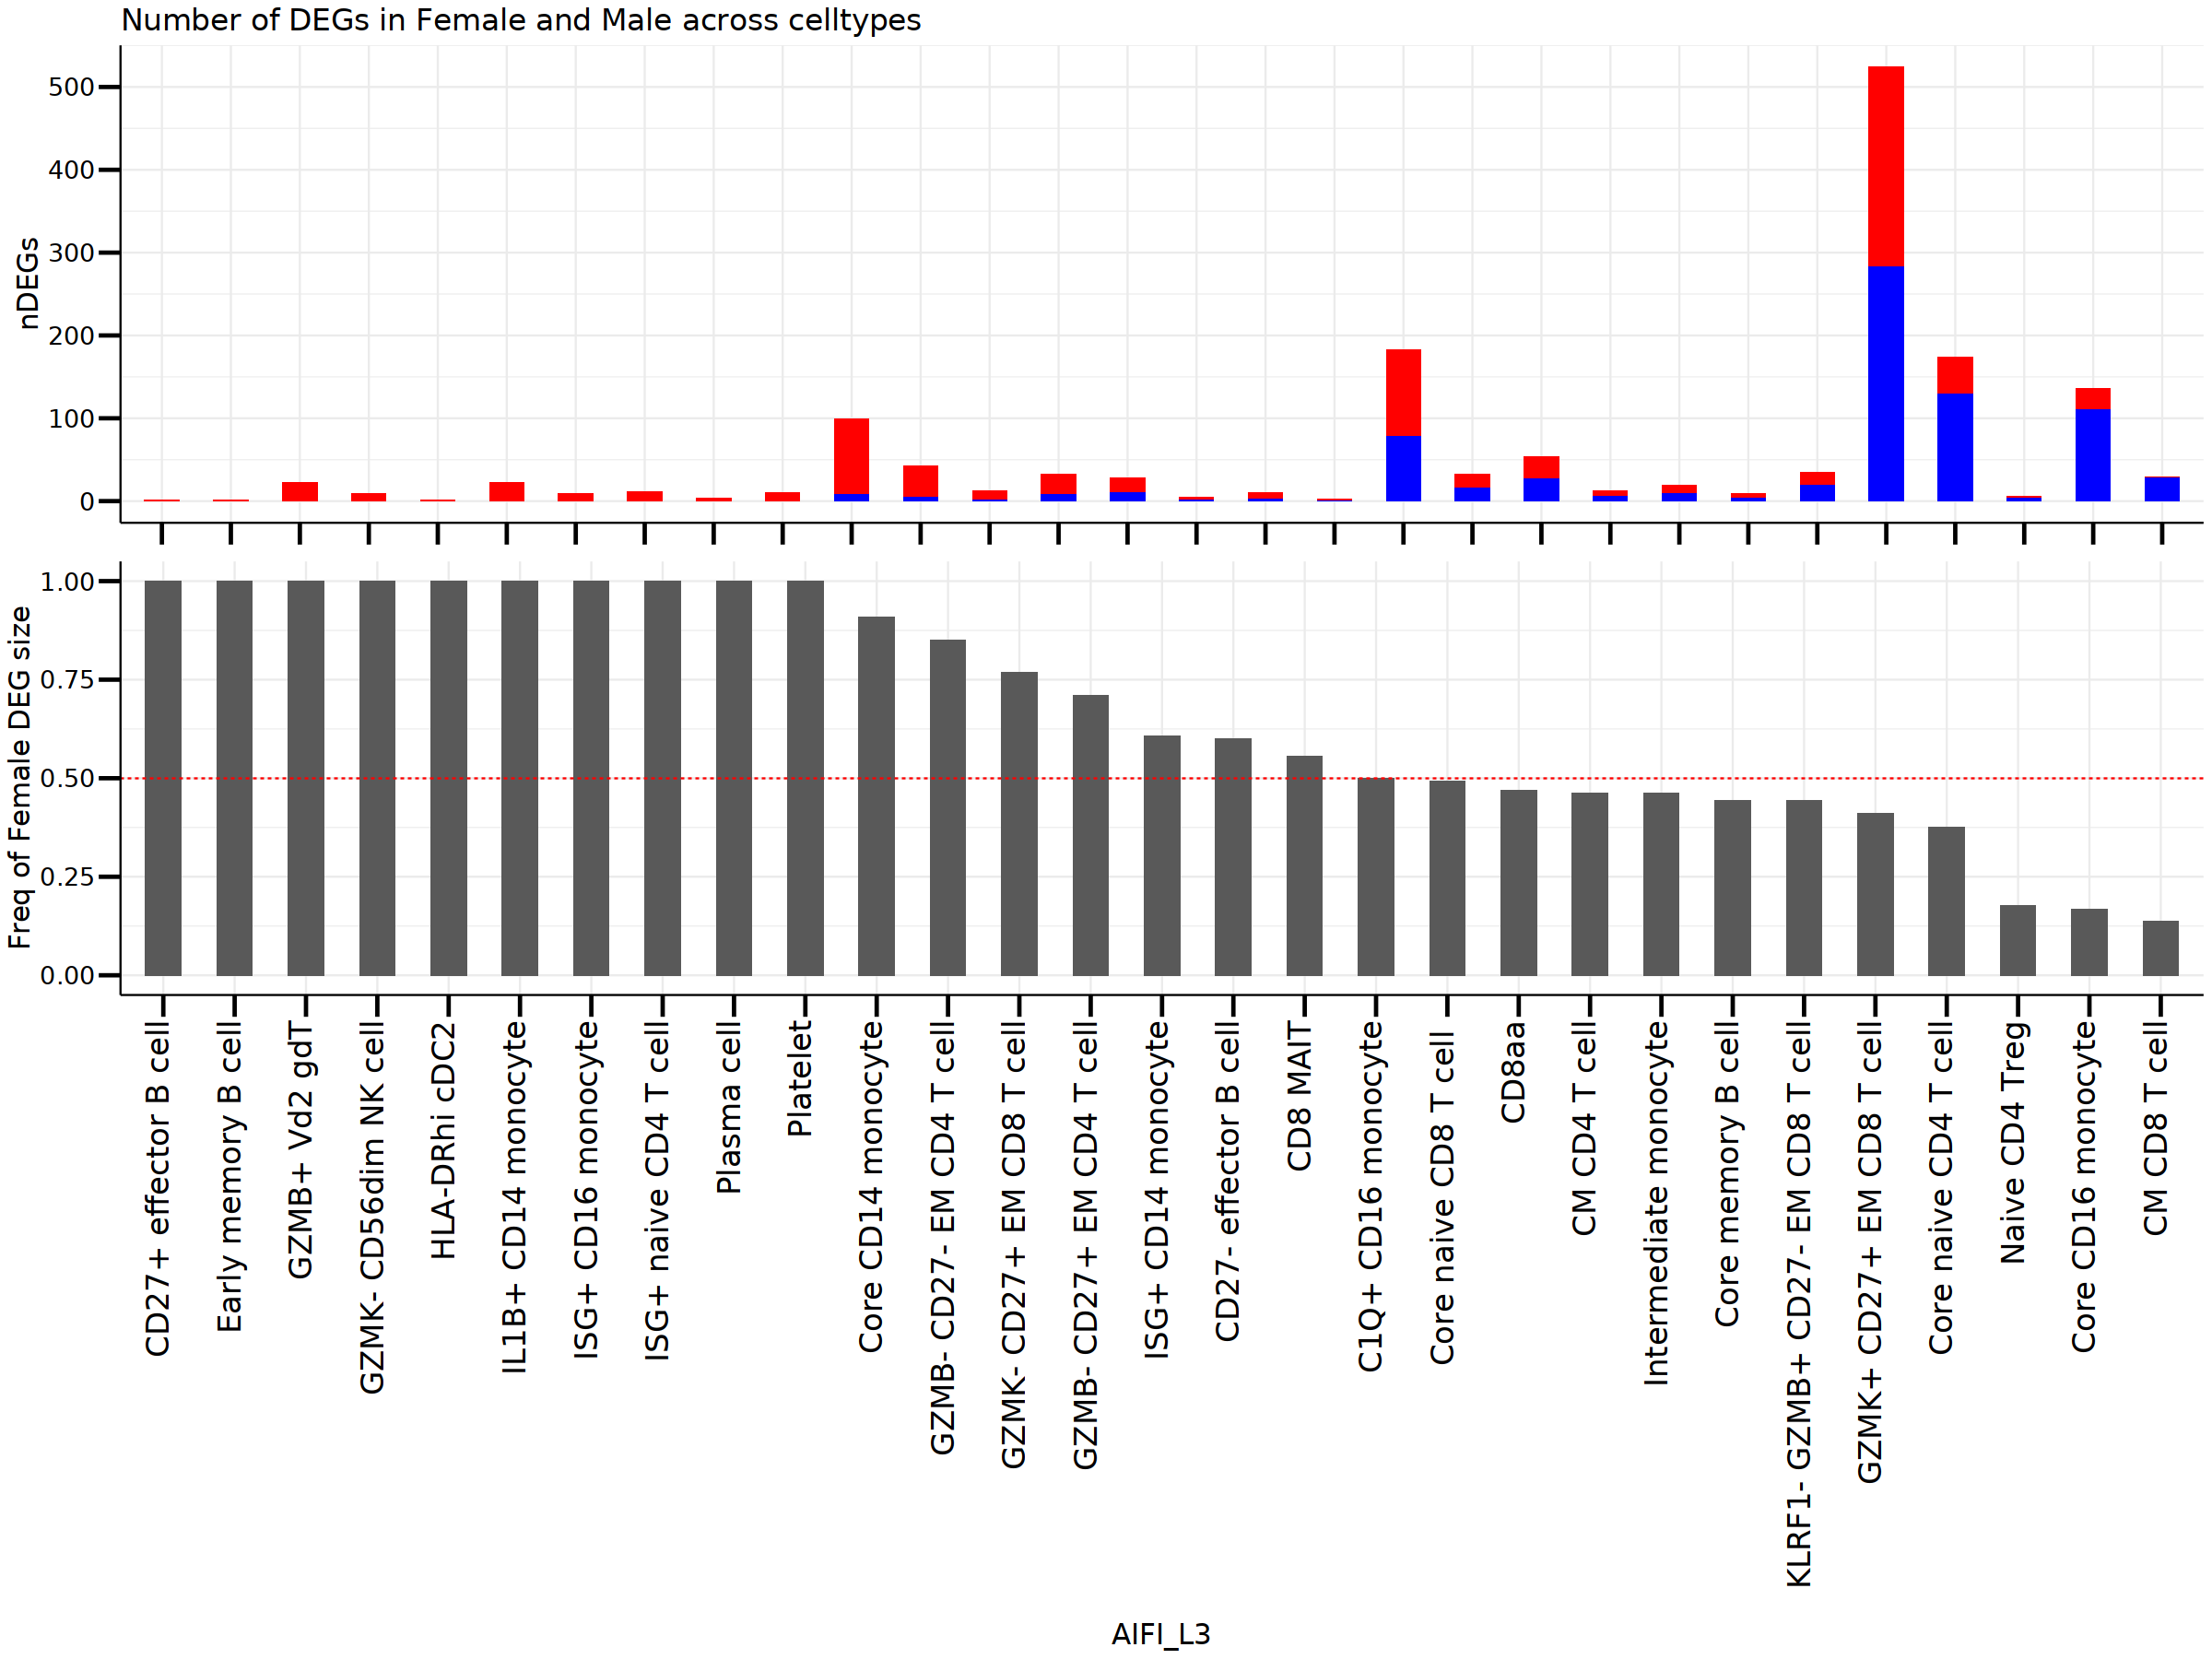

In [215]:
library(ggplot2)
library(cowplot)

# Assuming your dataframe is named df
# Replace df with the actual name of your dataframe if different

# Sort dataframe by Data_y in descending order
new_JI <- new_JI[order(-new_JI$Unique_F_ratio),]

# Convert cell_type to factor with levels arranged in descending order
new_JI$celltype <- factor(new_JI$celltype, levels = new_JI$celltype)

# Get the celltype order
celltype_order <- unique(new_JI$celltype)

# Plot 1: JI Plot
JI_plot <- ggplot(new_JI, aes(x = factor(celltype, levels = celltype_order), y = Unique_F_ratio)) +
  geom_bar(stat = "identity", width = 0.5) +  # Adjust width
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red") +
  theme_minimal() + 
  labs(x = "\nAIFI_L3", y = "Freq of Female DEG size") +
  theme(
    text = element_text(size = 16, color = "black"),
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),
    legend.title = element_blank(),
    legend.text = element_text(size = 16),
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", size = 0.5, linewidth = "solid"),
    axis.ticks.length  = unit(0.5, "cm")
  ) 

# Plot 2: nDEG Plot
pastel_colors <- c("red", "blue")  # Example pastel colors

nDEG_plot <- ggplot(master_complete, aes(x = factor(celltype, levels = celltype_order), y = count, fill = type)) +
  geom_bar(stat = "identity", width = 0.5) +  # Adjust width
  scale_fill_manual(values = pastel_colors) +
  labs(title = "Number of DEGs in Female and Male across celltypes", y = "nDEGs") +
  theme_minimal() +
  theme(
    text = element_text(size = 16, color = "black"),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),
    legend.title = element_blank(),
    legend.text = element_text(size = 16),
    axis.ticks = element_line(color = 1, linewidth = 1),
    axis.line = element_line(colour = "black", size = 0.5, linewidth = "solid"),
    axis.ticks.length  = unit(0.5, "cm")
  ) +
  theme(axis.title.x = element_blank(), axis.text.x = element_blank(), legend.position = "none")

# Adjust plot heights
options(repr.plot.width = 20, repr.plot.height = 15)

# Arrange plots vertically with proper alignment
plot_grid( nDEG_plot,JI_plot, align = "v", axis = "l", nrow = 2, ncol=1, rel_heights = c(1, 2), common.legend = TRUE, legend = "right")


In [188]:
library(gridExtra)

# Create the ratio plot using JI file (padj <0.05)

In [95]:
J_index <- read.csv("/home/jupyter/IH-A-Aging-Analysis-Notebooks_old/Mansi_Notebooks/scRNA/Figure_Notebooks/Intermediate_files/Jaccard_index_df_FvsM_each_celltype_padj0.05.csv")

In [96]:
#J_index

In [97]:
#Use DEG# in female/ DEG# (Female+Male-shared) on Y-axis and rank from high to low 
#     in X-axis in cell types that  have total DEGs # (f+M-s) > 10

In [98]:
J_index_modi <- J_index %>%
  mutate(Union = total_DEGs_female + total_DEGs_male - common_DEGs,
         Ratio_union = total_DEGs_female / Union,
        Unique_F_ratio = (total_DEGs_female-common_DEGs)/ Union)
         

# Print the updated dataframe
head(J_index_modi)


,X,celltype,jaccard_similarity,total_DEGs_male,total_DEGs_female,common_DEGs,Union,Ratio_union,Unique_F_ratio
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,1,Activated memory B cell,NA,0,0,0,0,NaN,NaN
2,2,Adaptive NK cell,NA,0,0,0,0,NaN,NaN
3,3,ASDC,NA,0,0,0,0,NaN,NaN
4,4,BaEoMaP cell,NA,0,0,0,0,NaN,NaN
5,5,C1Q+ CD16 monocyte,NA,0,0,0,0,NaN,NaN
6,6,CD14+ cDC2,NA,0,0,0,0,NaN,NaN


In [99]:
new_JI <- J_index_modi %>% filter(J_index_modi$Union > 10)
head(new_JI)
length(new_JI$celltype)
# new_JI <- J_index_modi
# head(new_JI)

,X,celltype,jaccard_similarity,total_DEGs_male,total_DEGs_female,common_DEGs,Union,Ratio_union,Unique_F_ratio
,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
1,12,CD8aa,0.00000000,6,10,0,16,0.6250000,0.6250000
2,16,CM CD4 T cell,0.05882353,6,12,1,17,0.7058824,0.6470588
3,17,CM CD8 T cell,0.06779661,50,13,4,59,0.2203390,0.1525424
4,19,Core CD14 monocyte,0.00000000,2,37,0,39,0.9487179,0.9487179
5,23,Core naive CD4 T cell,0.16666667,172,178,50,300,0.5933333,0.4266667
6,24,Core naive CD8 T cell,0.17241379,34,68,15,87,0.7816092,0.6091954


[1] 11

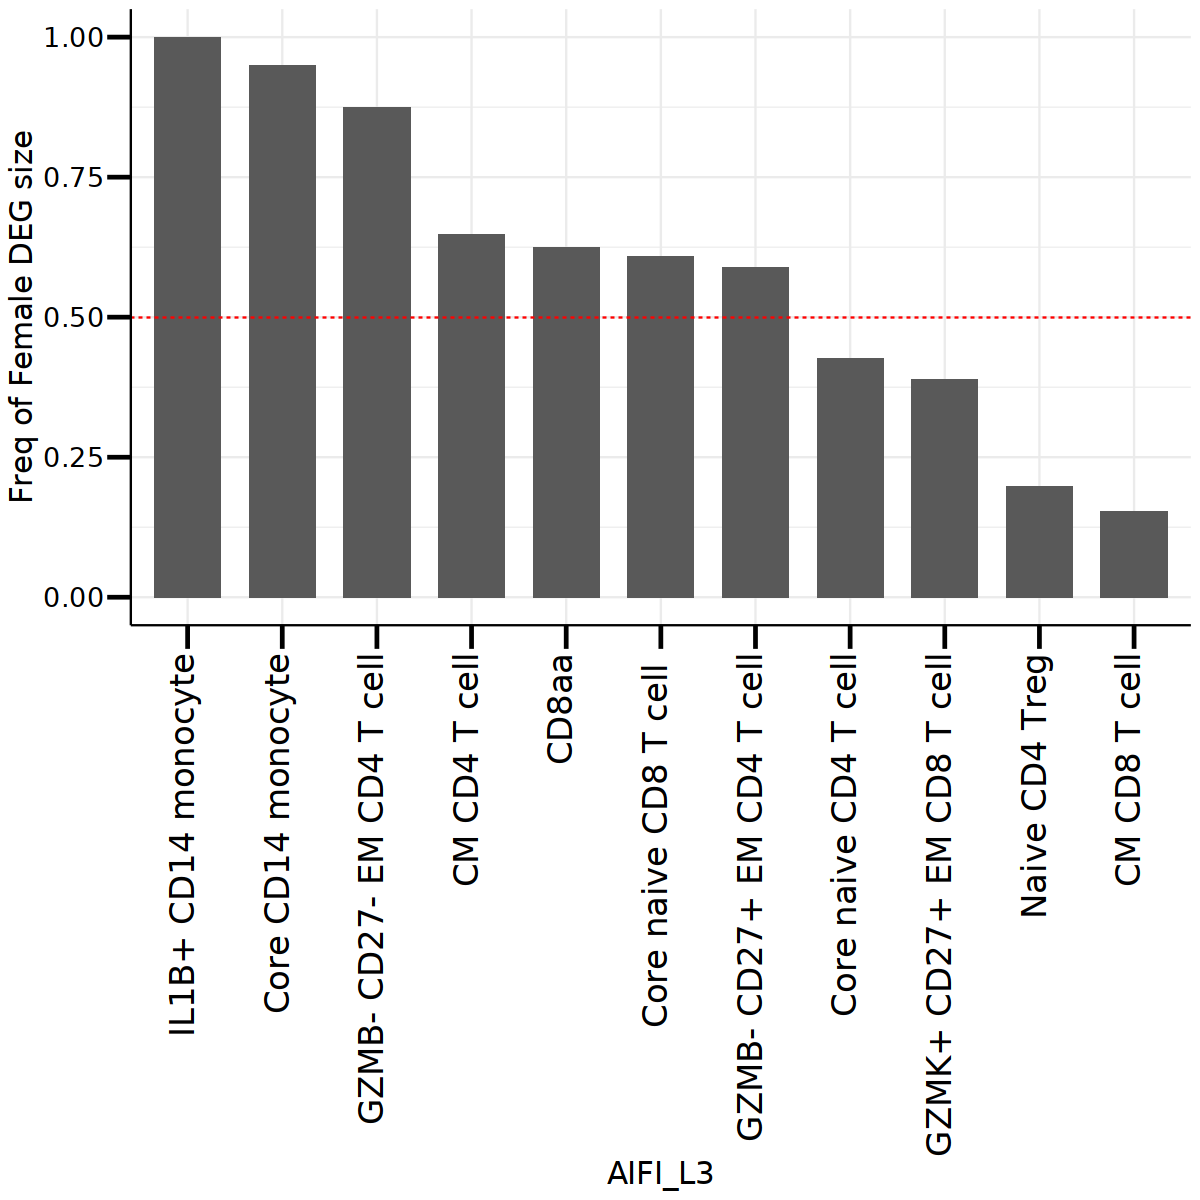

In [100]:
library(ggplot2)

# Assuming your dataframe is named df
# Replace df with the actual name of your dataframe if different

# Sort dataframe by Data_y in descending order
new_JI <- new_JI[order(-new_JI$Unique_F_ratio),]

# Convert cell_type to factor with levels arranged in descending order
new_JI$celltype <- factor(new_JI$celltype, levels = new_JI$celltype)

options(repr.plot.width = 10, repr.plot.height = 10)
# Create lollipop plot
lollipop_plot <- ggplot(new_JI, aes(x = celltype, y = Unique_F_ratio)) +
  geom_bar(stat = "identity", width = 0.7) +
  #geom_segment(aes(x = celltype, xend = celltype, y = 0, yend = Unique_F_ratio), color = "skyblue") +
  #geom_point(color = "blue", size = 3) +
  geom_hline(yintercept = 0.5, linetype = "dashed", color = "red")+
  theme_minimal() + 
  #coord_flip() + 
  labs(x = "AIFI_L3", y = "Freq of Female DEG size") +
  theme(
    text = element_text(size = 16, color = "black"),  # Enlarge text
    axis.text.x = element_text(size = 20, angle = 90, hjust = 1, color = "black", vjust= 0.25),  # Rotate x-axis labels
    axis.text.y = element_text(size = 16, color = "black"),
    axis.title = element_text(size = 18, color = "black"),  # Enlarge axis titles
    legend.title = element_blank(),  # Remove legend title
    legend.text = element_text(size = 16),  # Enlarge legend text
    axis.ticks = element_line(color = 1,linewidth = 1),
    axis.line = element_line(colour = "black", 
                      size = 0.5, linewidth = "solid"),# Set length of ticks
    axis.ticks.length  = unit(0.5, "cm")
  )   

# Print the plot
print(lollipop_plot)

